In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback
import glob
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from sklearn import preprocessing
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
import keras.backend as K
import scipy

os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [8]:
output_path = "/content/drive/MyDrive/labelled data/"

#omit participant p02, p18 and p20
participants = ["p" + str(i).zfill(2) for i in range(0, 25) if i != 2 and i != 18 and i != 20]
print(participants)

['p00', 'p01', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p19', 'p21', 'p22', 'p23', 'p24']


# **Pre-processing with StandardScaler()**

In [ ]:
def s(samples):
    #print(samples)
    std = np.std(samples)
    if std == 0:
        return samples - np.mean(samples)
    else:
        return (samples - np.mean(samples)) / std

def preprocess(df):
  scaler = preprocessing.StandardScaler() #MinMaxScaler
  names = df.columns
  fit = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(fit, columns=names)
  return scaled_df

**Get data with labels 0, 1, 2 (easy, medium, hard levels)**

In [ ]:
def get_only_stress_data(file):
    stress_data = pd.read_csv(file)
    stress_data = stress_data[(stress_data.label == 0) or (stress_data.label == 1) 
                              or (stress_data.label == 2)]
    return stress_data

# **Segmentation with window size 30 (without overlap)**













**All features sampled at 4Hz**

In [ ]:
eda_freq = 4

#without overlap
def get_data(pid):
    
    for f in os.listdir(output_path):
        if f.startswith(str(pid)) and f.endswith("EDA.csv"):
            eda_path = f
        elif f.startswith(str(pid)) and f.endswith("TEMP.csv"):
            temp_path = f
        elif f.startswith(str(pid)) and f.endswith("BVP.csv"):
            bvp_path = f
        elif f.startswith(str(pid)) and f.endswith("HR.csv"):
            hr_path = f
        elif f.startswith(str(pid)) and f.endswith("ACC.csv"):
            acc_path = f

    eda_data_raw = get_only_stress_data(output_path + eda_path)
    temp_data_raw_all = get_only_stress_data(output_path + temp_path)
    bvp_data_raw_all = get_only_stress_data(output_path + bvp_path)
    hr_data_raw_all = get_only_stress_data(output_path + hr_path)
    acc_data_raw_all = get_only_stress_data(output_path + acc_path)

    bvp_data_raw_arr = scipy.signal.resample(bvp_data_raw_all['bvp'], len(eda_data_raw['eda']))
    temp_data_raw_arr = scipy.signal.resample(temp_data_raw_all['temp'], len(eda_data_raw['eda']))
    hr_data_raw_arr = scipy.signal.resample(hr_data_raw_all['bpm'], len(eda_data_raw['eda']))
    acc_x_data_raw_arr = scipy.signal.resample(acc_data_raw_all['x'], len(eda_data_raw['eda']))
    acc_y_data_raw_arr = scipy.signal.resample(acc_data_raw_all['y'], len(eda_data_raw['eda']))
    acc_z_data_raw_arr = scipy.signal.resample(acc_data_raw_all['z'], len(eda_data_raw['eda']))

    df_bvp = pd.DataFrame(bvp_data_raw_arr, columns = ['bvp'])
    df_temp = pd.DataFrame(temp_data_raw_arr, columns = ['temp'])
    df_hr = pd.DataFrame(hr_data_raw_arr, columns = ['bpm'])
    df_acc_x = pd.DataFrame(acc_x_data_raw_arr, columns = ['x'])
    df_acc_y = pd.DataFrame(acc_y_data_raw_arr, columns = ['y'])
    df_acc_z = pd.DataFrame(acc_z_data_raw_arr, columns = ['z'])
    df_eda = pd.DataFrame(eda_data_raw['eda'], columns= ['eda'])

    eda_data = preprocess(df_eda)
    temp_data = preprocess(df_temp)
    bvp_data = preprocess(df_bvp)
    hr_data = preprocess(df_hr)
    acc_x_data = preprocess(df_acc_x)
    acc_y_data = preprocess(df_acc_y)
    acc_z_data = preprocess(df_acc_z)

    data_merged = pd.concat([eda_data, temp_data, bvp_data, acc_x_data, acc_y_data, acc_z_data], axis=1)

    data_as_np = data_merged.to_numpy() 

    win_size = 30; X=[]; label=[];

    for i in range(win_size, int(len(eda_data_raw['eda']) / eda_freq)):

        X.append(s(data_as_np[eda_freq * (i - win_size): eda_freq * i]))

        l = eda_data_raw["label"][eda_freq * (i - win_size): eda_freq * i]
        lp = np.bincount(np.array(l)).argmax()
        label.append(lp)
    
    return { "data": np.array(X, dtype=object), 
            "label": np.array(label)}

In [ ]:
all_data = [get_data(pid) for pid in participants]

In [ ]:
for i in range(len(all_data)):
        print(all_data[i]['data'].shape)
        print(all_data[i]['label'].shape)

In [ ]:
scores = []
acc_per_sub, loss_per_sub = [], []
f1_per_sub, prec_per_sub, rec_per_sub = [], [], []
conf_matrix_per_sub = []

# **Transformers model**

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

#**Reshape, fit and evaluate the model**

In [ ]:
def transformers(train_data, test_data):

    num_transformer_blocks = 2
    head_size = 256
    num_heads = 4
    dropout = 0.25
    ff_dim = 4
    mlp_units=[128]
    mlp_dropout=0.4

    models = []
  
    X_train = [] 
    X_train = train_data['data'].astype(np.float32) #.reshape(train_data.shape[0],train_data.shape[1], train_data.shape[2])
    y_train = train_data["label"]

    X_test = []
    X_test = test_data['data'].astype(np.float32) #.reshape(test_data.shape[0],test_data.shape[1], test_data.shape[2])
    y_test = test_data["label"]
    
    input = keras.layers.Input(shape=(train_data['data'].shape[1], train_data['data'].shape[2]))
    x = input

    for _ in range(num_transformer_blocks):
        transformer_layer = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    pooling_layer = layers.GlobalAveragePooling1D(data_format="channels_first")(transformer_layer)

    for dim in mlp_units:
        dense_layer = layers.Dense(dim, activation="relu")(pooling_layer)
        drop_out = layers.Dropout(mlp_dropout)(dense_layer)

    output_layer = keras.layers.Dense(3, activation="softmax")(drop_out)

    model = tf.keras.Model(inputs=input, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=30, batch_size=128, 
                         validation_data=(X_test, y_test), verbose=0) 
    scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    acc_per_sub.append(scores[1] * 100)
    loss_per_sub.append(scores[0])

    y_pred = np.argmax(model.predict(X_test), axis=1)
    f1_per_sub.append(f1_score(y_test, y_pred, average='weighted'))
    prec_per_sub.append(precision_score(y_test, y_pred, average='weighted'))
    rec_per_sub.append(recall_score(y_test, y_pred, average='weighted'))  

    #y_pred = np.argmax(model.predict(X_test), axis=1)
    print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
    print('Precision: ',precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ',recall_score(y_test, y_pred, average='weighted'))

    pd.DataFrame(history.history).plot(figsize=(6, 5))
    plt.show()
        
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    conf_matrix_per_sub.append(cm)
    print(cm)
    ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Reds')
    ax.figsize=(5,5)
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ax.xaxis.set_ticklabels(['0','1','2'])
    ax.yaxis.set_ticklabels(['0','1','2'])

    plt.show()

    return conf_matrix_per_sub, acc_per_sub, loss_per_sub, f1_per_sub, prec_per_sub, rec_per_sub

# **Without finetuning test data (LOSO)**



SUBJECT 0
8/8 [==============================] - 0s 5ms/step - loss: 0.8490 - accuracy: 0.5885
Score : loss of 0.8490088582038879; accuracy of 58.84907841682434%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.5006996656307962
Precision:  0.5049367730408183
Recall:  0.5884907709011944


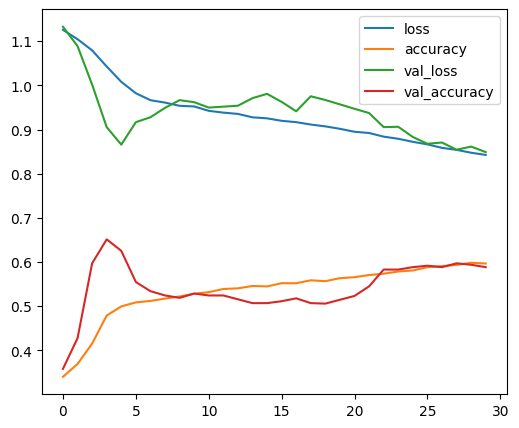

[[ 15 214  84]
 [  0 286  28]
 [ 37  16 241]]


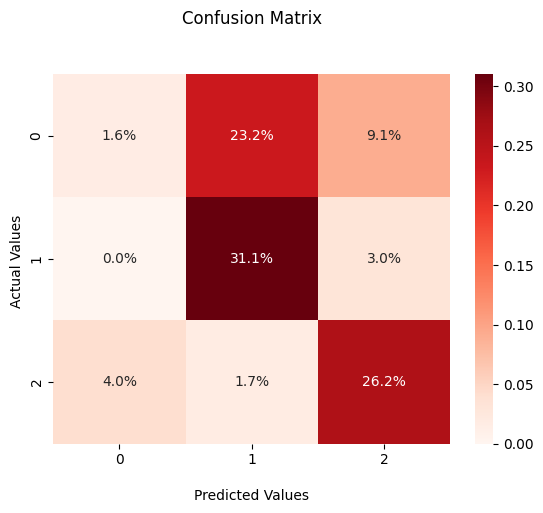

SUBJECT 1
8/8 [==============================] - 0s 6ms/step - loss: 3.5038 - accuracy: 0.1085
Score : loss of 3.5037989616394043; accuracy of 10.848549753427505%
30/30 [==============================] - 0s 2ms/step
F1 score:  0.12651597361931513
Precision:  0.21891205975766184
Recall:  0.10848549946294307


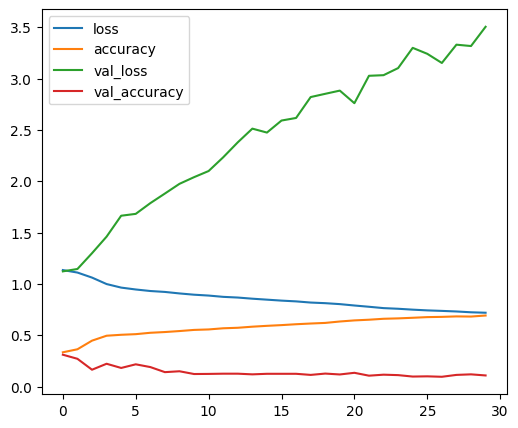

[[ 42  53 214]
 [ 36  59 223]
 [  4 300   0]]


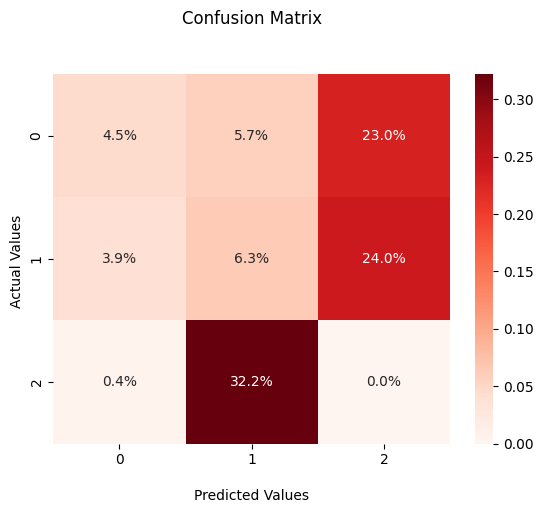

SUBJECT 2
8/8 [==============================] - 0s 6ms/step - loss: 1.7546 - accuracy: 0.4865
Score : loss of 1.7546299695968628; accuracy of 48.64864945411682%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.4203285366465915
Precision:  0.42182022895414634
Recall:  0.4864864864864865


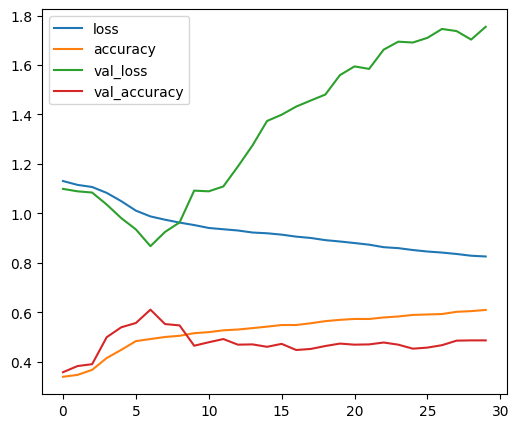

[[189  95  28]
 [ 32 261  18]
 [  0 302   0]]


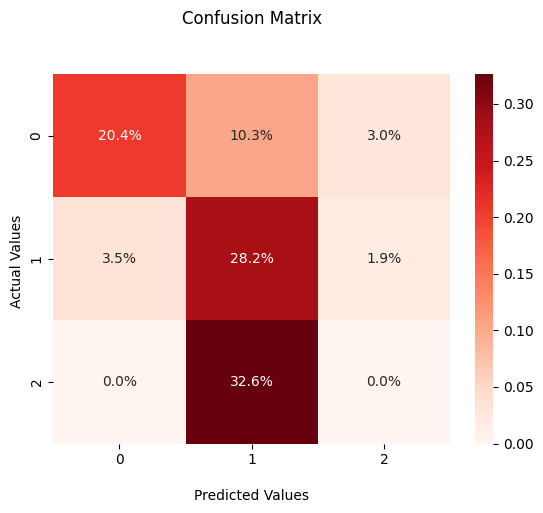

SUBJECT 3
8/8 [==============================] - 0s 6ms/step - loss: 0.9236 - accuracy: 0.5070
Score : loss of 0.9236162304878235; accuracy of 50.70422291755676%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.47451521893553145
Precision:  0.5054176281818187
Recall:  0.5070422535211268


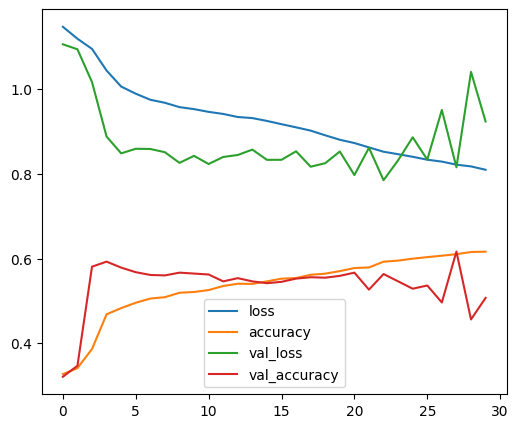

[[  9 286   1]
 [ 60 268   0]
 [ 81  27 191]]


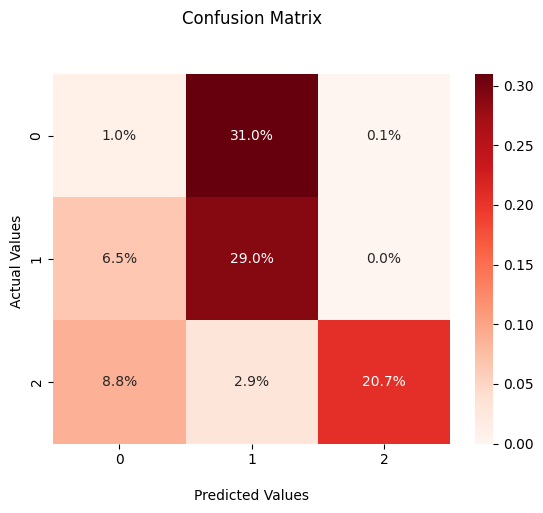

SUBJECT 4
8/8 [==============================] - 0s 6ms/step - loss: 2.7902 - accuracy: 0.2424
Score : loss of 2.7901878356933594; accuracy of 24.235807359218597%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.20952893544159623
Precision:  0.2574471466933116
Recall:  0.2423580786026201


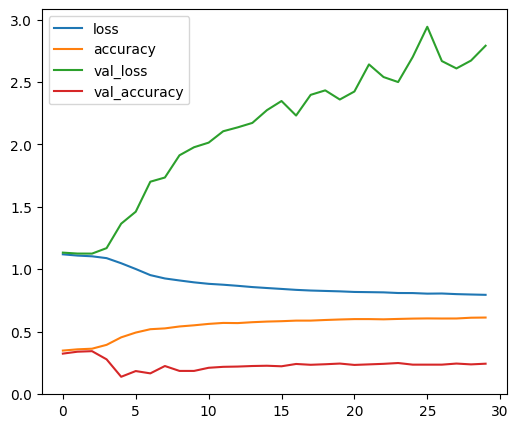

[[ 40 144 113]
 [  2 178 135]
 [ 47 253   4]]


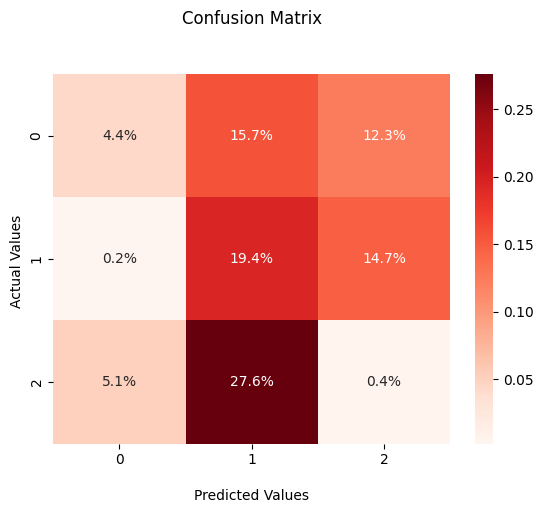

SUBJECT 5
8/8 [==============================] - 0s 6ms/step - loss: 1.9697 - accuracy: 0.1891
Score : loss of 1.9696886539459229; accuracy of 18.907104432582855%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.15989664973111842
Precision:  0.14174670281447344
Recall:  0.18907103825136612


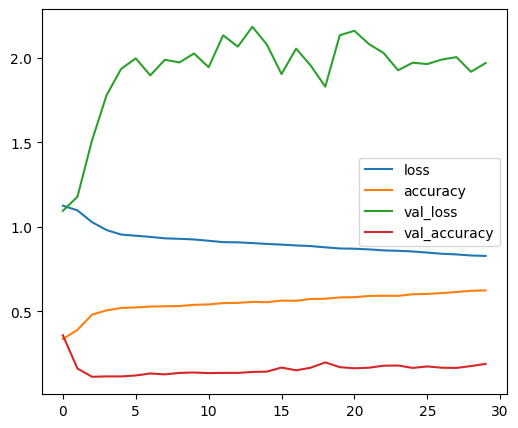

[[  3  26 271]
 [ 53 170  91]
 [ 59 242   0]]


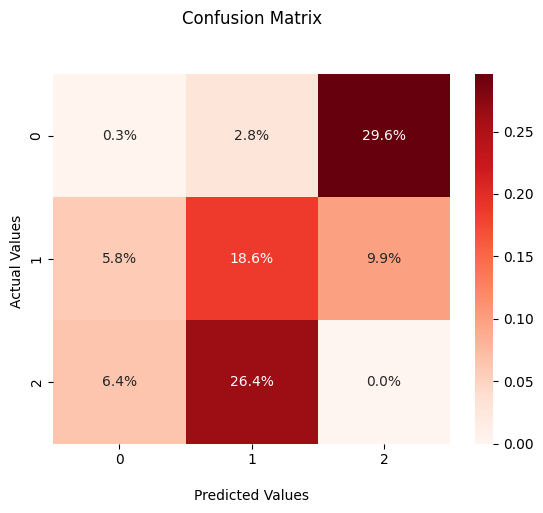

SUBJECT 6
8/8 [==============================] - 0s 5ms/step - loss: 1.4482 - accuracy: 0.3103
Score : loss of 1.4482300281524658; accuracy of 31.034481525421143%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.27729038813272266
Precision:  0.2518398657694982
Recall:  0.3103448275862069


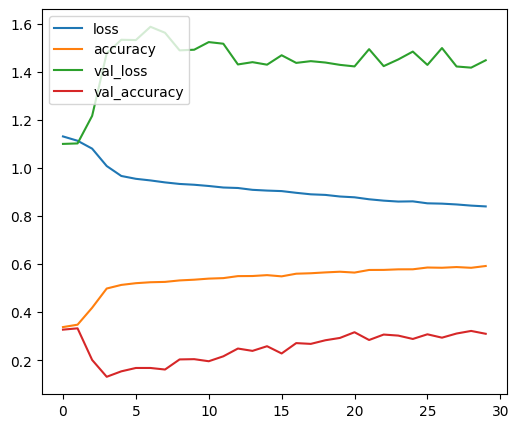

[[137  86  84]
 [ 98 151  66]
 [190 116   0]]


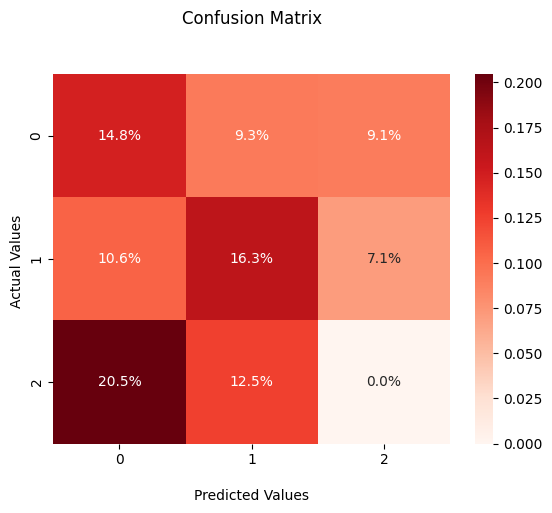

SUBJECT 7
8/8 [==============================] - 0s 5ms/step - loss: 0.8595 - accuracy: 0.5478
Score : loss of 0.8594560027122498; accuracy of 54.78261113166809%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.5357176669869488
Precision:  0.5442163490046255
Recall:  0.5478260869565217


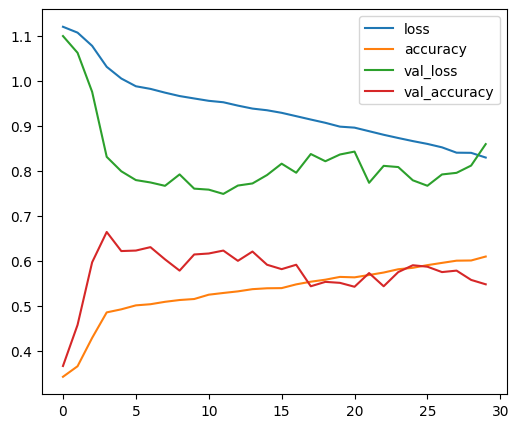

[[ 81 205  23]
 [ 86 185  42]
 [ 25  35 238]]


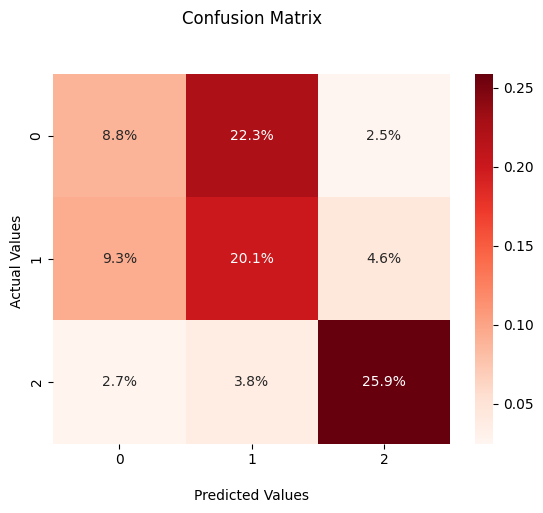

SUBJECT 8
8/8 [==============================] - 0s 6ms/step - loss: 0.9108 - accuracy: 0.5596
Score : loss of 0.9107864499092102; accuracy of 55.96432685852051%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.4841203652388871
Precision:  0.5003500210529268
Recall:  0.5596432552954292


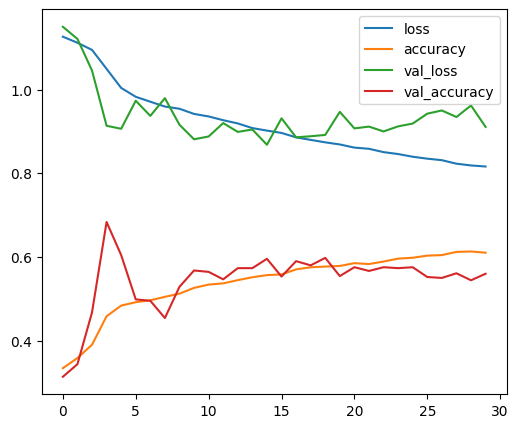

[[ 20  91 191]
 [ 10 278  21]
 [ 27  55 204]]


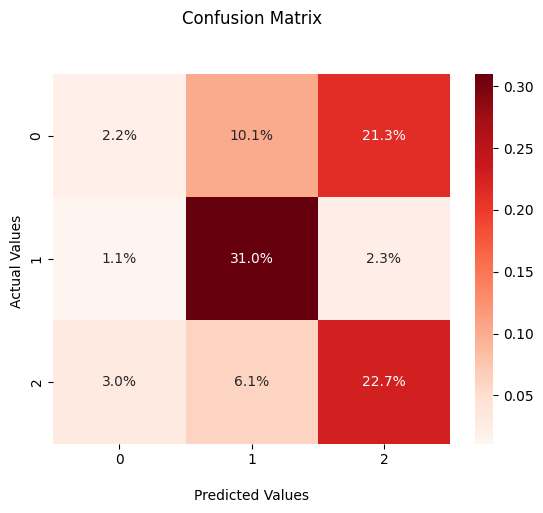

SUBJECT 9
8/8 [==============================] - 0s 7ms/step - loss: 1.0672 - accuracy: 0.4645
Score : loss of 1.0672434568405151; accuracy of 46.44808769226074%
29/29 [==============================] - 0s 3ms/step
F1 score:  0.44552636475958685
Precision:  0.43558291922896664
Recall:  0.4644808743169399


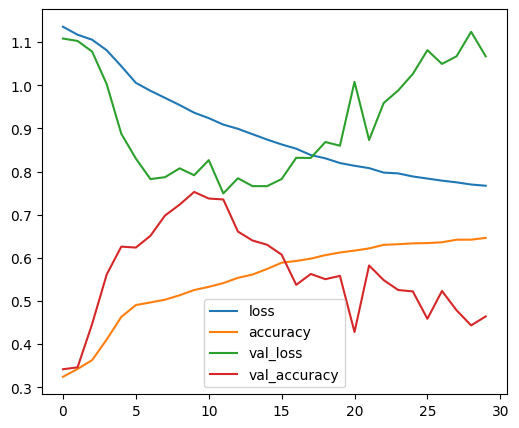

[[114  68 120]
 [ 34 252  32]
 [171  65  59]]


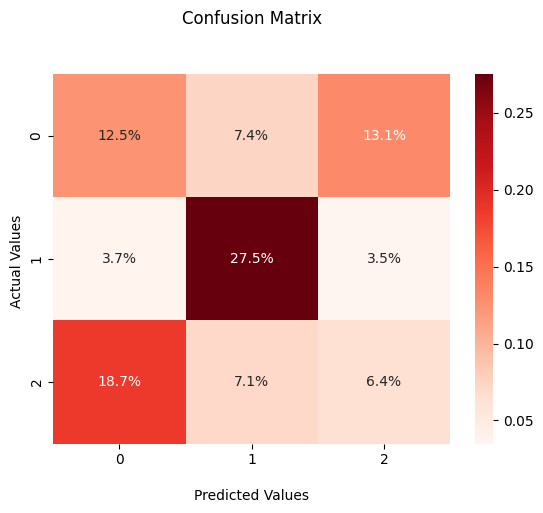

SUBJECT 10
8/8 [==============================] - 0s 6ms/step - loss: 1.0413 - accuracy: 0.4140
Score : loss of 1.0413265228271484; accuracy of 41.39728844165802%
30/30 [==============================] - 0s 3ms/step
F1 score:  0.3596049305277511
Precision:  0.3182041383347453
Recall:  0.41397288842544316


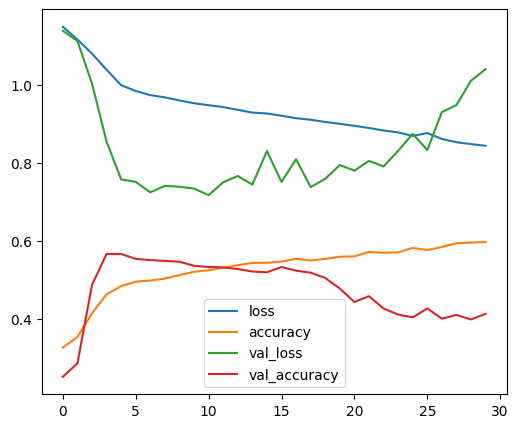

[[  0 322   0]
 [ 95 118 113]
 [ 13  19 279]]


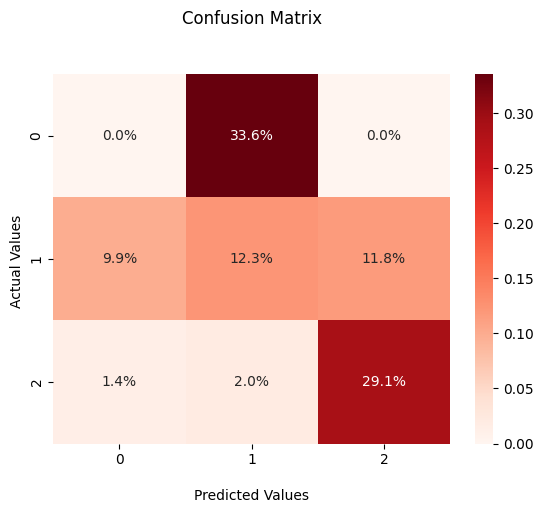

SUBJECT 11
8/8 [==============================] - 0s 6ms/step - loss: 1.3831 - accuracy: 0.4571
Score : loss of 1.383069634437561; accuracy of 45.71118354797363%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.4638201049904503
Precision:  0.4882127989767955
Recall:  0.4571118349619978


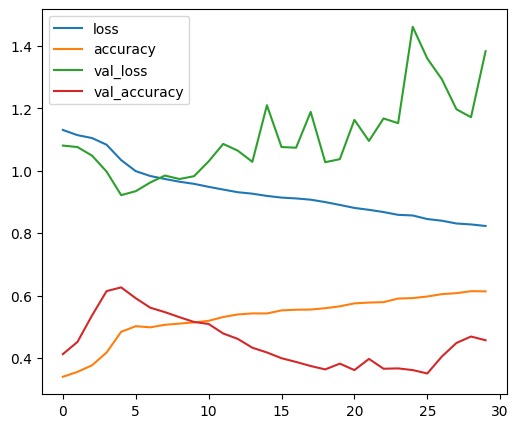

[[125 174   0]
 [ 46 127 148]
 [ 27 105 169]]


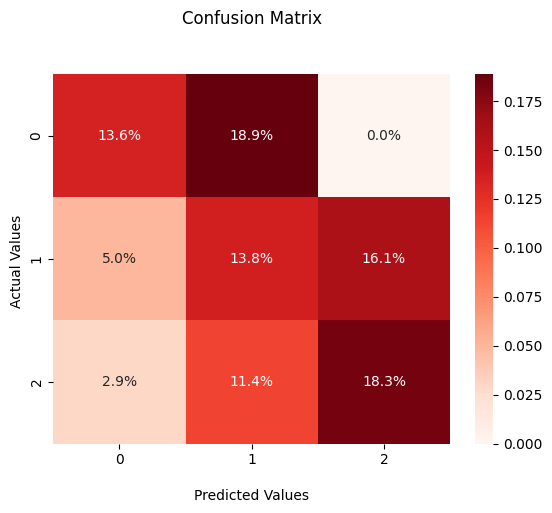

SUBJECT 12
8/8 [==============================] - 0s 6ms/step - loss: 0.9609 - accuracy: 0.5407
Score : loss of 0.960908055305481; accuracy of 54.07488942146301%
29/29 [==============================] - 0s 3ms/step
F1 score:  0.5423443698546273
Precision:  0.5644149478372447
Recall:  0.5407488986784141


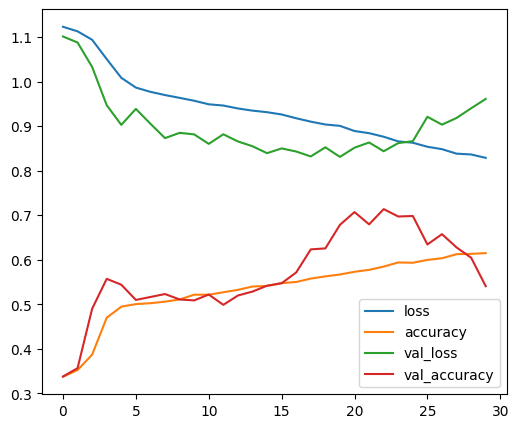

[[183  31  78]
 [130 167   9]
 [100  69 141]]


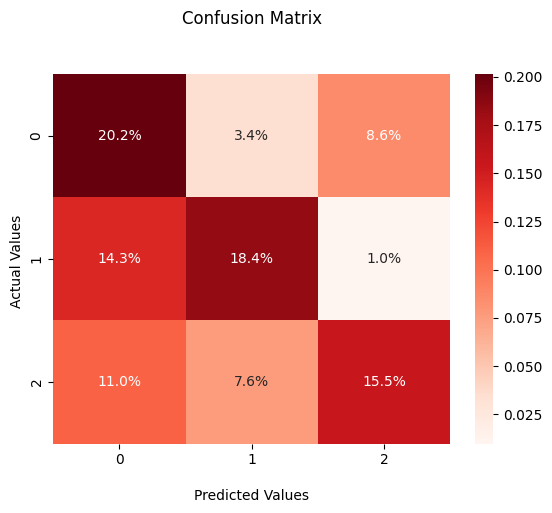

SUBJECT 13
8/8 [==============================] - 0s 6ms/step - loss: 0.9063 - accuracy: 0.5403
Score : loss of 0.9062610864639282; accuracy of 54.03050184249878%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.48269032887735036
Precision:  0.48023221743135075
Recall:  0.5403050108932462


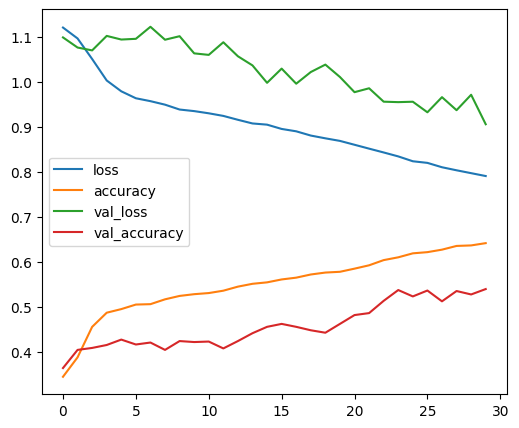

[[ 28 191  80]
 [  7 316   0]
 [103  41 152]]


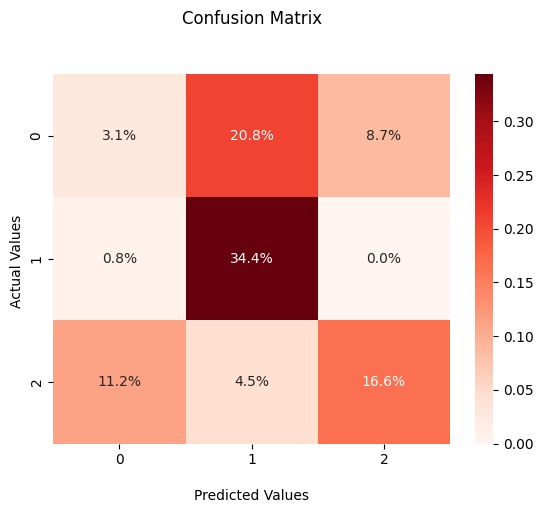

SUBJECT 14
8/8 [==============================] - 0s 7ms/step - loss: 1.2821 - accuracy: 0.4134
Score : loss of 1.2821322679519653; accuracy of 41.339001059532166%
30/30 [==============================] - 0s 2ms/step
F1 score:  0.38205001173808917
Precision:  0.5623022188146221
Recall:  0.41339001062699254


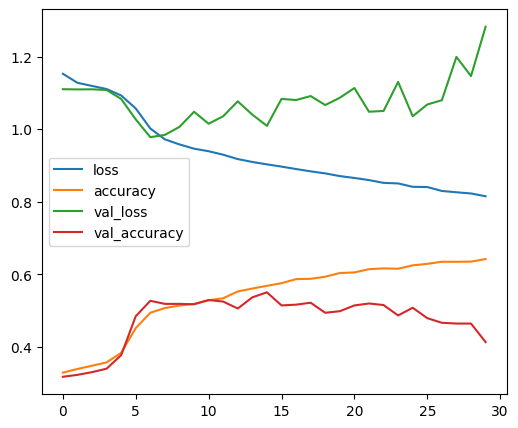

[[ 76 223   2]
 [ 73 247   0]
 [100 154  66]]


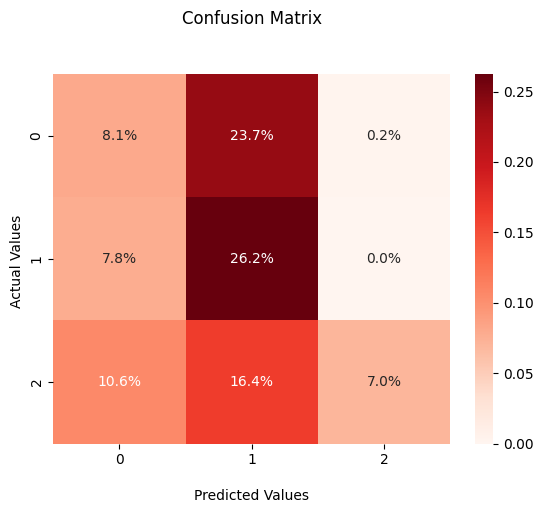

SUBJECT 15
8/8 [==============================] - 0s 6ms/step - loss: 1.1585 - accuracy: 0.3729
Score : loss of 1.1584982872009277; accuracy of 37.293729186058044%
29/29 [==============================] - 0s 3ms/step
F1 score:  0.3657628912075791
Precision:  0.37553393474644664
Recall:  0.37293729372937295


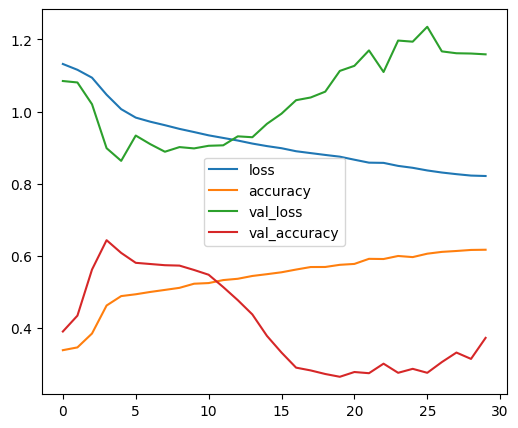

[[ 76 233   4]
 [ 54  76 169]
 [ 63  47 187]]


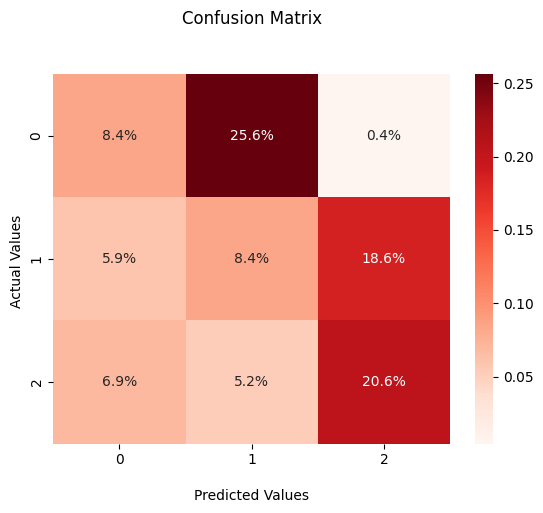

SUBJECT 16
8/8 [==============================] - 0s 6ms/step - loss: 1.7664 - accuracy: 0.1519
Score : loss of 1.7663519382476807; accuracy of 15.193966031074524%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.1434237981143666
Precision:  0.14244620923469847
Recall:  0.15193965517241378


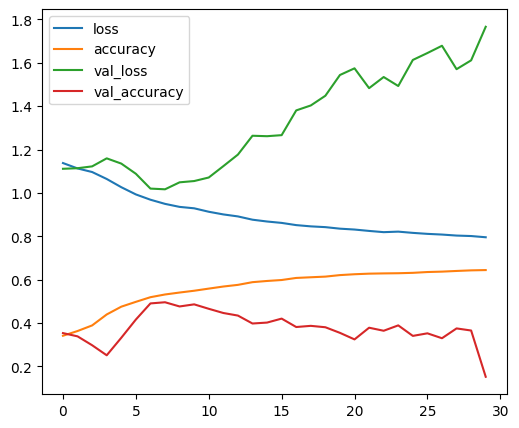

[[  1 310   6]
 [ 52  95 165]
 [228  26  45]]


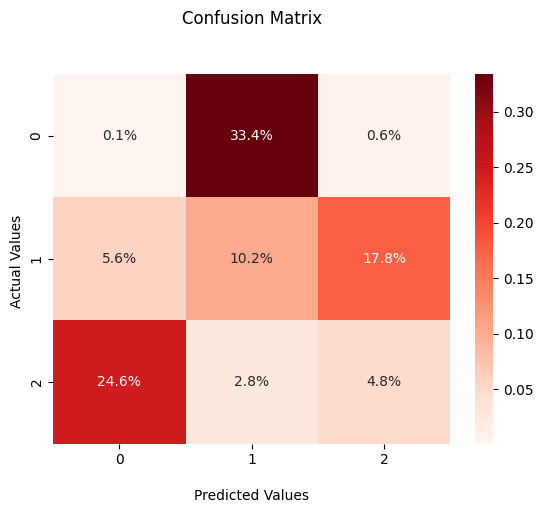

SUBJECT 17
8/8 [==============================] - 0s 6ms/step - loss: 1.6367 - accuracy: 0.2449
Score : loss of 1.6367312669754028; accuracy of 24.49197918176651%
30/30 [==============================] - 0s 2ms/step
F1 score:  0.24673427047457322
Precision:  0.24903014098201265
Recall:  0.2449197860962567


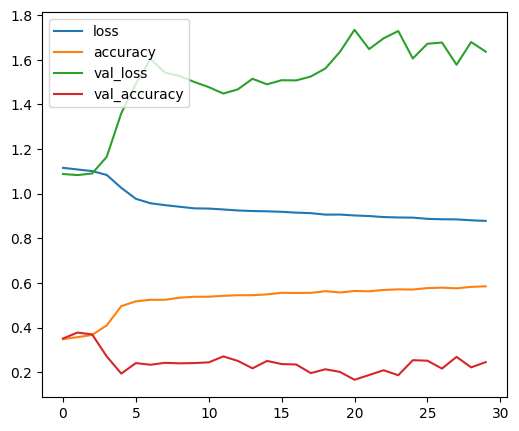

[[146  64 113]
 [ 38  83 188]
 [120 183   0]]


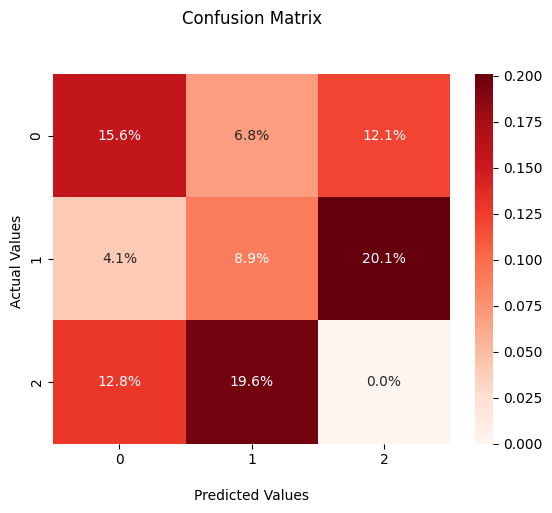

SUBJECT 18
8/8 [==============================] - 0s 6ms/step - loss: 0.9775 - accuracy: 0.5955
Score : loss of 0.9774521589279175; accuracy of 59.54692363739014%
29/29 [==============================] - 0s 3ms/step
F1 score:  0.5870436374255794
Precision:  0.585297446819975
Recall:  0.5954692556634305


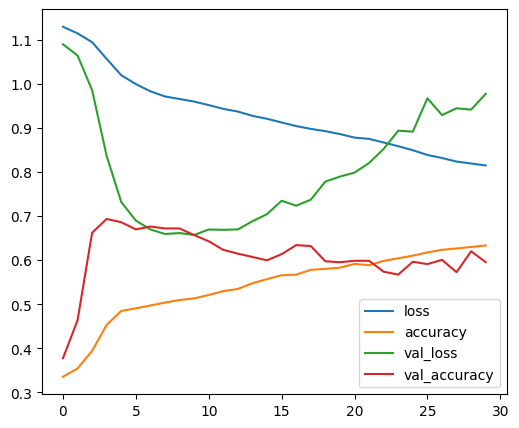

[[114 196   8]
 [122 157  33]
 [ 12   4 281]]


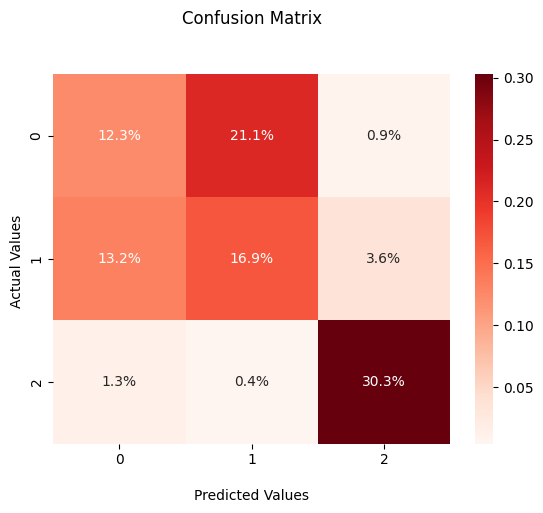

SUBJECT 19
8/8 [==============================] - 0s 6ms/step - loss: 0.7543 - accuracy: 0.5476
Score : loss of 0.7543106079101562; accuracy of 54.756635427474976%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.5359680619248416
Precision:  0.528066400557203
Recall:  0.547566371681416


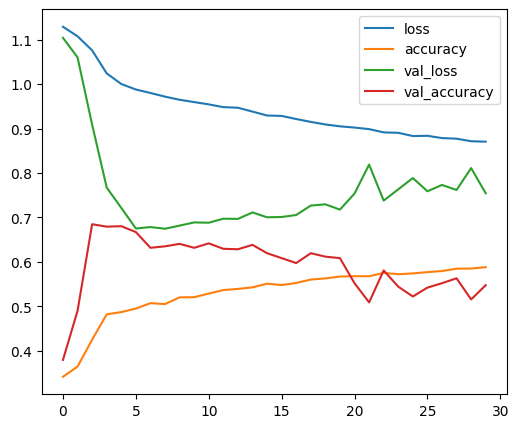

[[107 139  61]
 [191 113   0]
 [  1  17 275]]


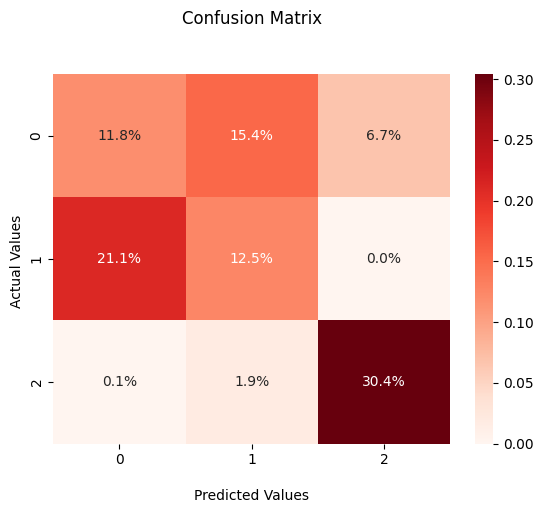

SUBJECT 20
8/8 [==============================] - 0s 6ms/step - loss: 1.3542 - accuracy: 0.2213
Score : loss of 1.3542461395263672; accuracy of 22.125813364982605%
29/29 [==============================] - 0s 3ms/step
F1 score:  0.17035599839814008
Precision:  0.13996849905991862
Recall:  0.22125813449023862


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


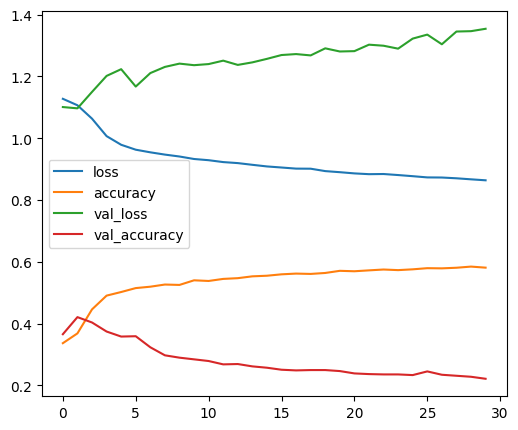

[[152 164   0]
 [248  52   0]
 [155 151   0]]


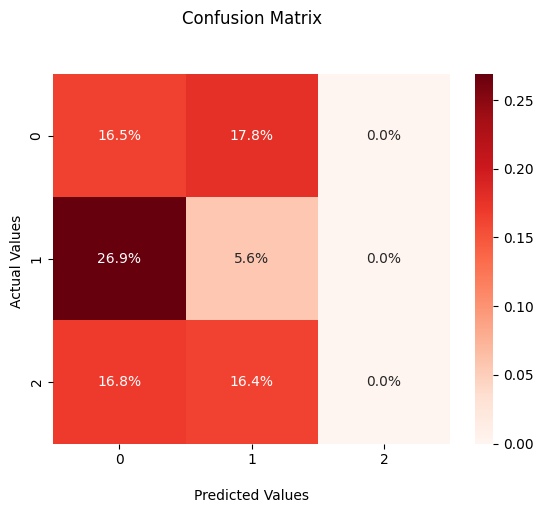

SUBJECT 21
8/8 [==============================] - 0s 6ms/step - loss: 1.8264 - accuracy: 0.3815
Score : loss of 1.8264492750167847; accuracy of 38.147738575935364%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.28158634373255254
Precision:  0.27281193336928045
Recall:  0.3814773980154355


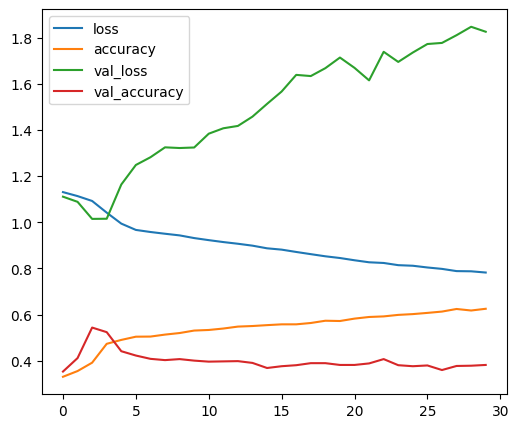

[[  6 178 125]
 [ 15 287   0]
 [ 43 200  53]]


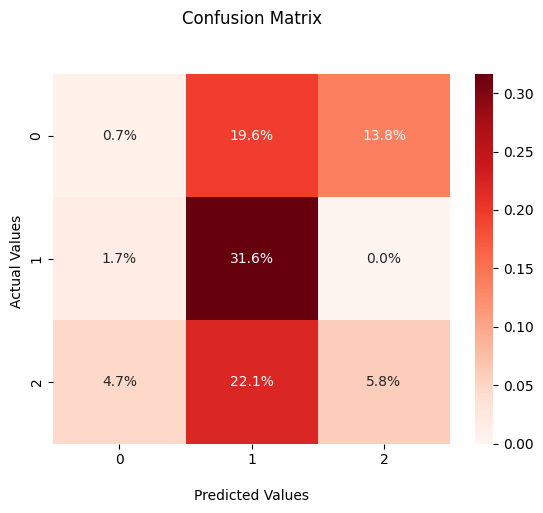

In [ ]:
for sub in range(len(all_data)):

    print('SUBJECT',sub)

    train_data = {}
    
    train_data["data"] = np.concatenate([all_data[i]["data"] for i in range(len(all_data)) if i != sub])    
    
    train_data["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    
    test_data = all_data[sub]
    cm_w_o_ft, acc_w_o_ft, loss_w_o_ft, f1_w_o_ft, prec_w_o_ft, rec_w_o_ft = transformers(train_data, test_data)

**Average accuracy and F1 score (no ft)**

In [2]:
print(acc_w_o_ft)

[58.84907841682434, 10.848549753427505, 48.64864945411682, 50.70422291755676, 24.235807359218597, 18.907104432582855, 31.034481525421143, 54.78261113166809, 55.96432685852051, 46.44808769226074, 41.39728844165802, 45.71118354797363, 54.07488942146301, 54.03050184249878, 41.339001059532166, 37.293729186058044, 15.193966031074524, 24.49197918176651, 59.54692363739014, 54.756635427474976, 22.125813364982605, 38.147738575935364]


In [1]:
print(np.mean(acc_w_o_ft))
print(np.mean(f1_w_o_ft))

40.38784405724569
0.3725238414722271


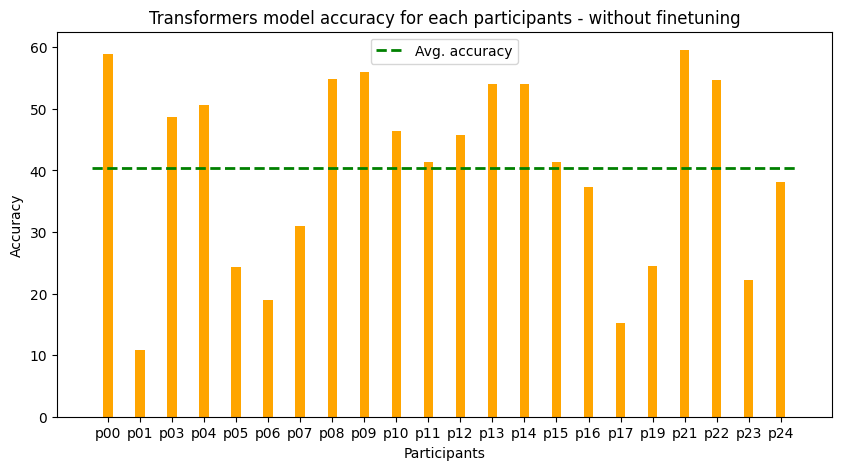

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_o_ft, color ='orange',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Transformers model accuracy for each participants - without finetuning")

plt.hlines(y=(np.mean(acc_w_o_ft)), xmin=-0.5, xmax=(len(acc_w_o_ft)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

# **Finetuning 5% of test data (LOSO)**

SUBJECT 0
7/7 [==============================] - 0s 5ms/step - loss: 1.1365 - accuracy: 0.5217
Score : loss of 1.1365240812301636; accuracy of 52.173912525177%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.45980066257338964
Precision:  0.5087524823753106
Recall:  0.5217391304347826


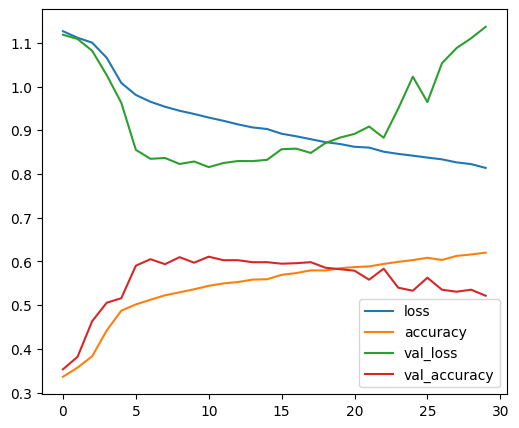

[[ 36 170  90]
 [  5 286   9]
 [ 40 104 134]]


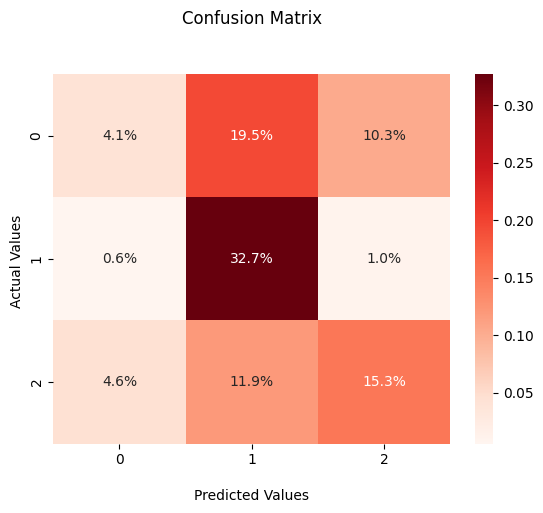

SUBJECT 1
7/7 [==============================] - 0s 5ms/step - loss: 2.3404 - accuracy: 0.2183
Score : loss of 2.340447187423706; accuracy of 21.832579374313354%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.1603700746806551
Precision:  0.18597132714779774
Recall:  0.21832579185520362


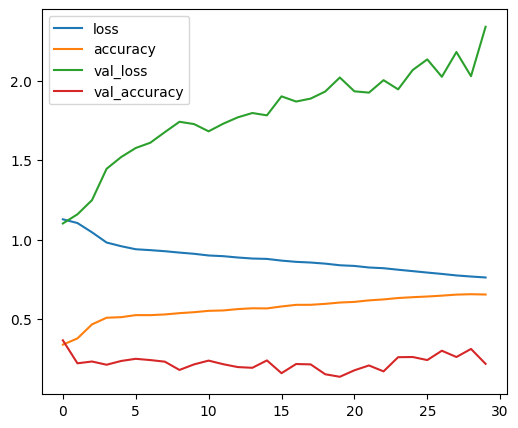

[[ 11 124 159]
 [ 34 182  86]
 [  0 288   0]]


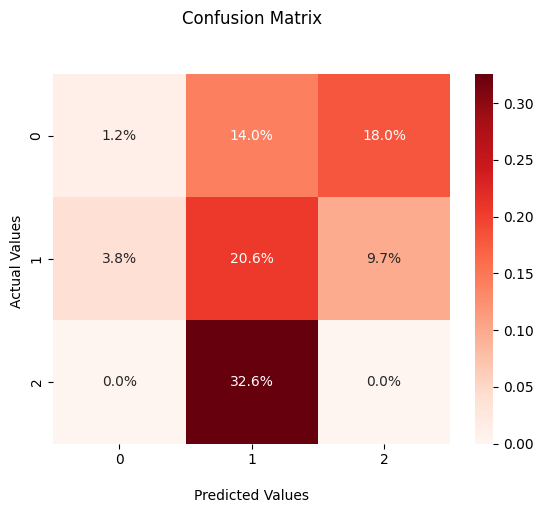

SUBJECT 2
7/7 [==============================] - 0s 6ms/step - loss: 1.6640 - accuracy: 0.4670
Score : loss of 1.6640255451202393; accuracy of 46.697038412094116%
28/28 [==============================] - 0s 3ms/step
F1 score:  0.3823659424084225
Precision:  0.44428241393171836
Recall:  0.46697038724373574


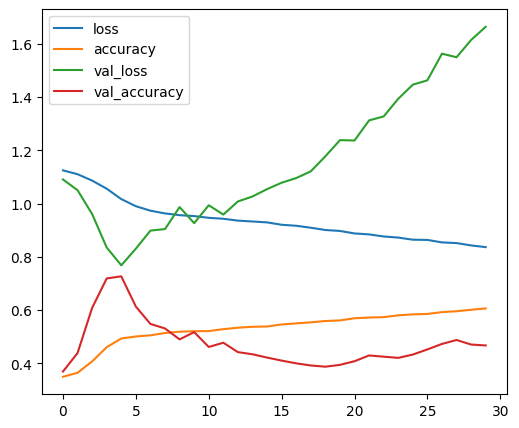

[[126 155  17]
 [  7 284   0]
 [  3 286   0]]


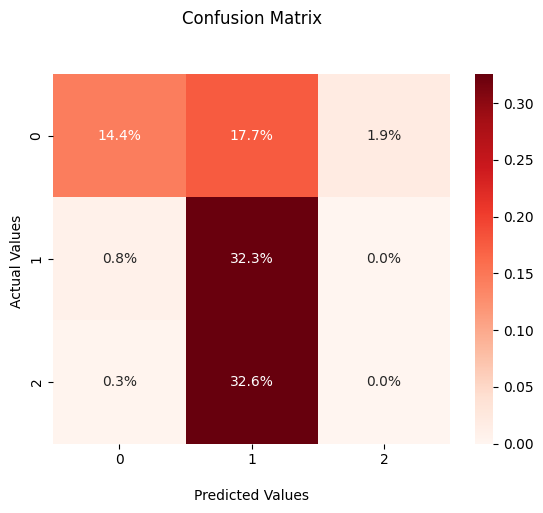

SUBJECT 3
7/7 [==============================] - 0s 6ms/step - loss: 1.1951 - accuracy: 0.4178
Score : loss of 1.1951313018798828; accuracy of 41.78082048892975%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.4010141751414246
Precision:  0.3906813094428934
Recall:  0.4178082191780822


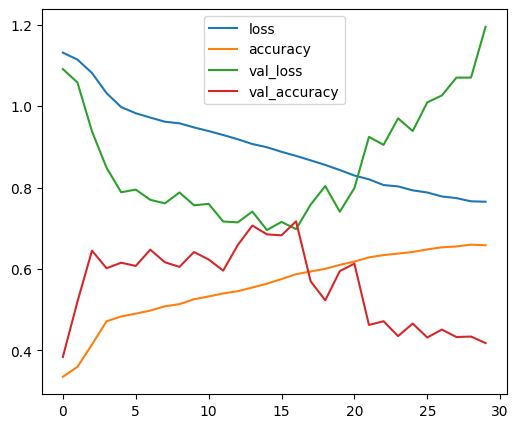

[[ 27 242  14]
 [127 113  67]
 [ 34  26 226]]


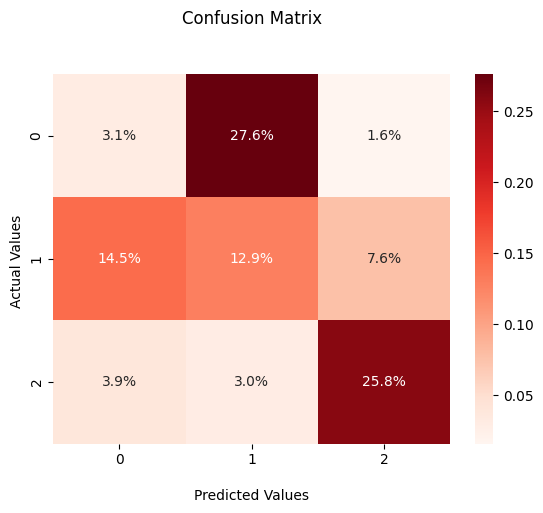

SUBJECT 4
7/7 [==============================] - 0s 6ms/step - loss: 1.9299 - accuracy: 0.1977
Score : loss of 1.929909110069275; accuracy of 19.770115613937378%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.1796472795060919
Precision:  0.1749377361017652
Recall:  0.19770114942528735


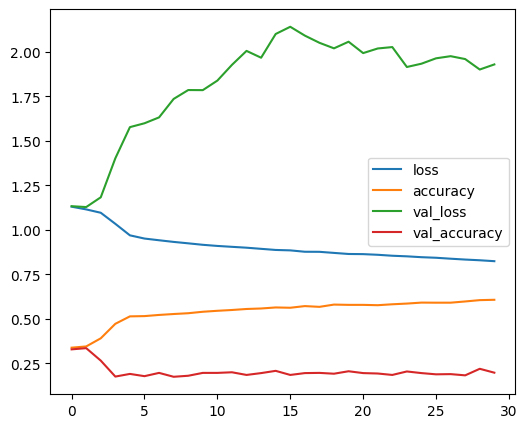

[[ 31  92 158]
 [ 36 141 123]
 [103 186   0]]


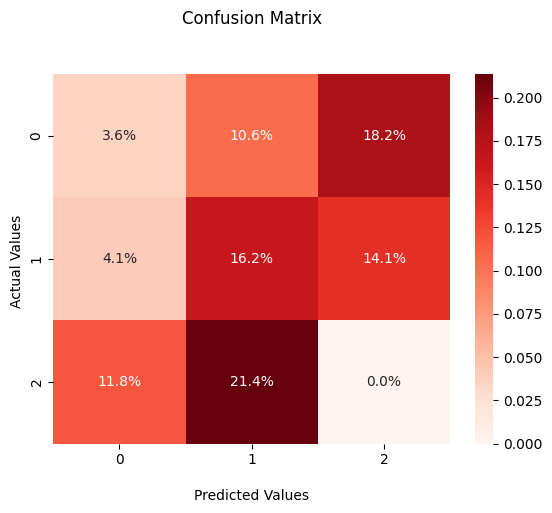

SUBJECT 5
7/7 [==============================] - 0s 6ms/step - loss: 2.0774 - accuracy: 0.1703
Score : loss of 2.077354907989502; accuracy of 17.031070590019226%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.14871510862464063
Precision:  0.1319799045850391
Recall:  0.17031070195627157


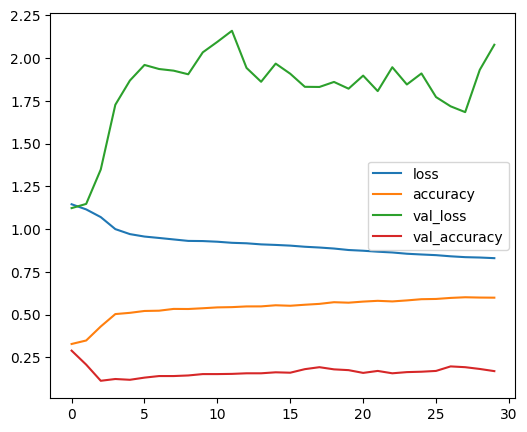

[[  0  25 255]
 [ 77 148  78]
 [ 68 218   0]]


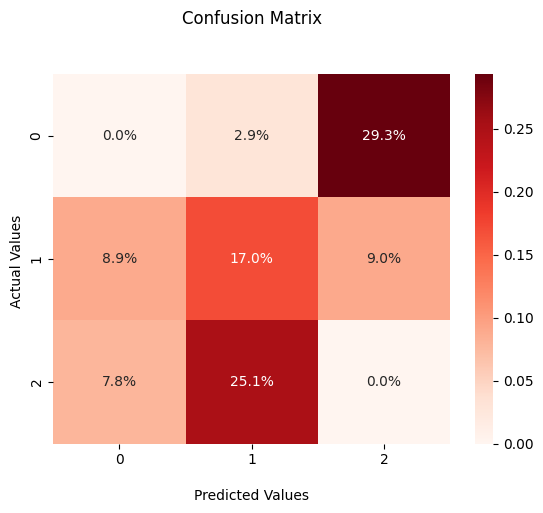

SUBJECT 6
7/7 [==============================] - 0s 6ms/step - loss: 1.3931 - accuracy: 0.3825
Score : loss of 1.393075704574585; accuracy of 38.25198709964752%
28/28 [==============================] - 0s 3ms/step
F1 score:  0.3259845178304169
Precision:  0.2841608474676077
Recall:  0.38251986379114644


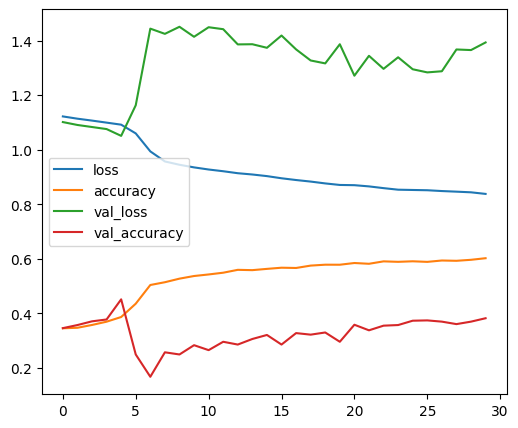

[[139  80  77]
 [ 97 198   1]
 [180 109   0]]


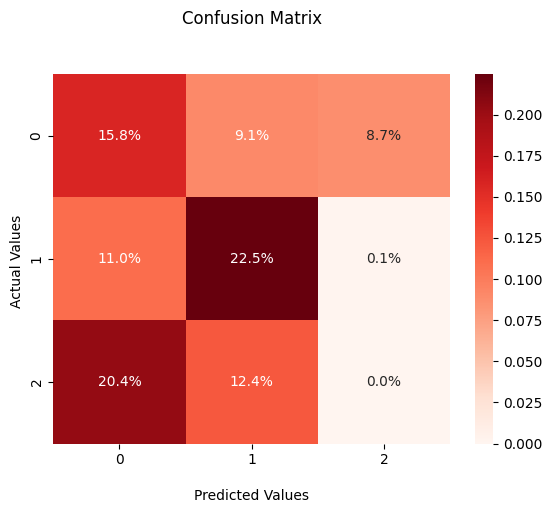

SUBJECT 7
7/7 [==============================] - 0s 6ms/step - loss: 0.8066 - accuracy: 0.6018
Score : loss of 0.8066026568412781; accuracy of 60.18306612968445%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.5696103043394812
Precision:  0.6269005963273806
Recall:  0.6018306636155606


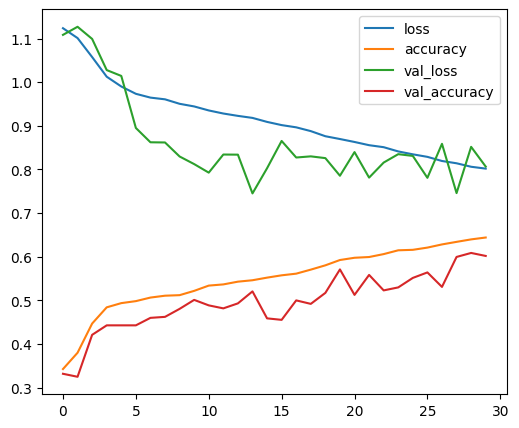

[[ 47 253   0]
 [ 46 242   3]
 [ 11  35 237]]


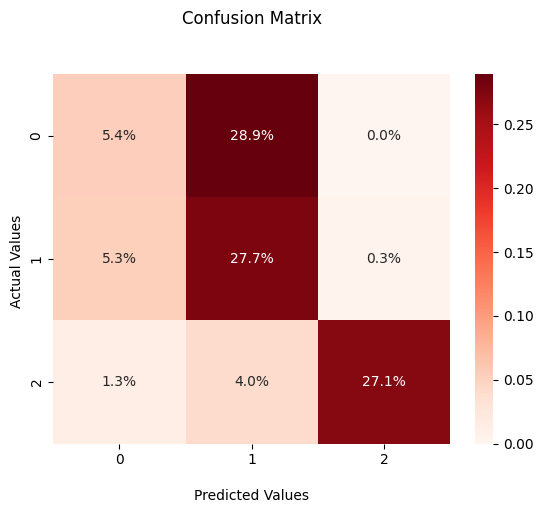

SUBJECT 8
7/7 [==============================] - 0s 5ms/step - loss: 0.9240 - accuracy: 0.5810
Score : loss of 0.9240244626998901; accuracy of 58.09859037399292%
27/27 [==============================] - 0s 2ms/step
F1 score:  0.5688158288609431
Precision:  0.6769276539569243
Recall:  0.5809859154929577


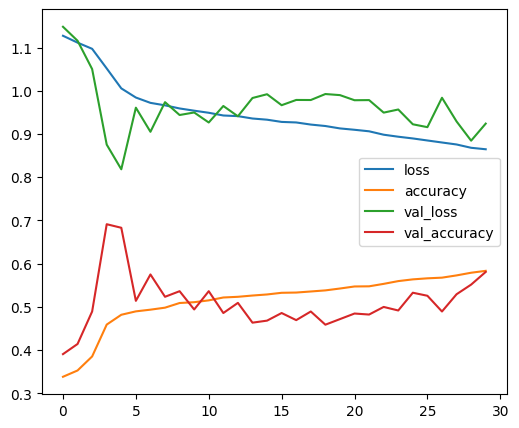

[[106 175   5]
 [ 11 263  19]
 [ 28 119 126]]


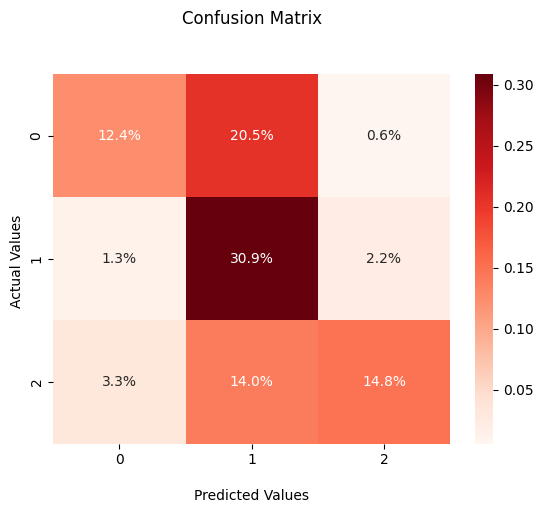

SUBJECT 9
7/7 [==============================] - 0s 6ms/step - loss: 0.8155 - accuracy: 0.6674
Score : loss of 0.8154929876327515; accuracy of 66.74338579177856%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.631093562135641
Precision:  0.7857187348428566
Recall:  0.667433831990794


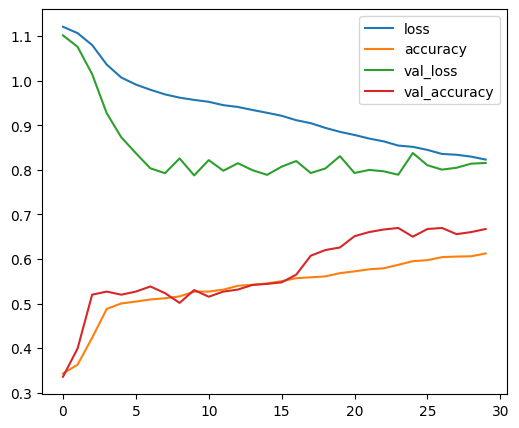

[[ 68 197  22]
 [  1 304   2]
 [  3  64 208]]


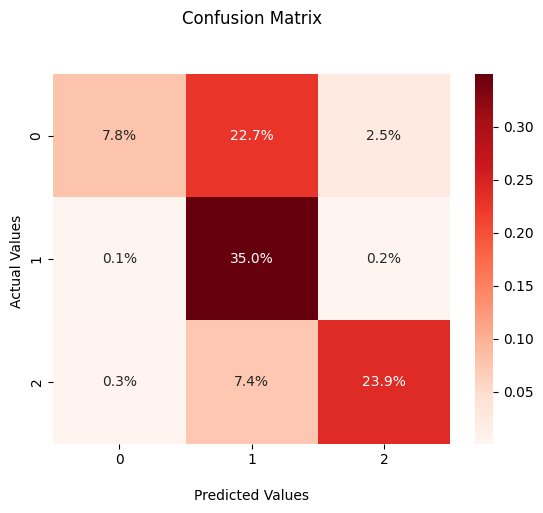

SUBJECT 10
8/8 [==============================] - 0s 7ms/step - loss: 1.2195 - accuracy: 0.4742
Score : loss of 1.2194968461990356; accuracy of 47.42041826248169%
29/29 [==============================] - 0s 2ms/step
F1 score:  0.425781398105113
Precision:  0.45917642530307834
Recall:  0.47420417124039516


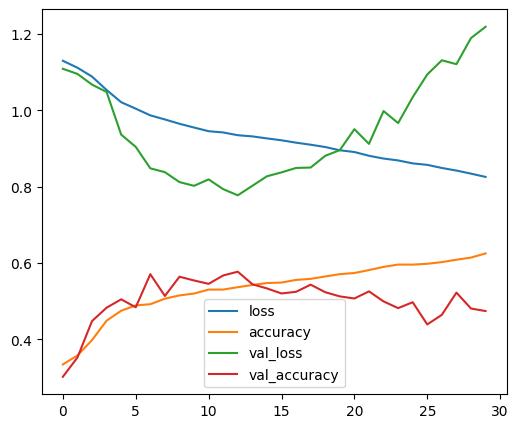

[[ 56 182  72]
 [ 57  97 150]
 [  0  18 279]]


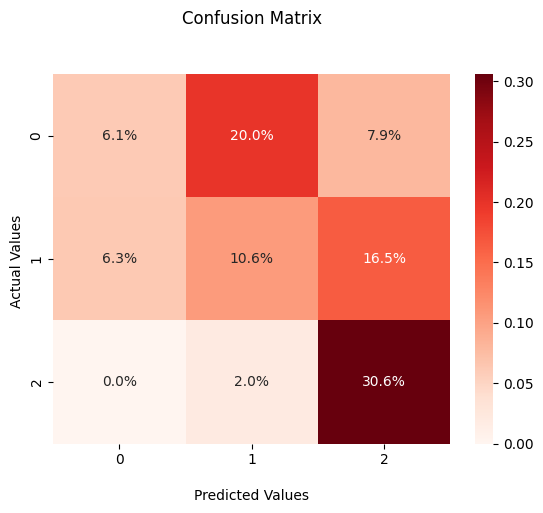

SUBJECT 11
7/7 [==============================] - 0s 5ms/step - loss: 1.3728 - accuracy: 0.6041
Score : loss of 1.3728270530700684; accuracy of 60.41190028190613%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.5914968860708303
Precision:  0.5933956380690543
Recall:  0.6041189931350115


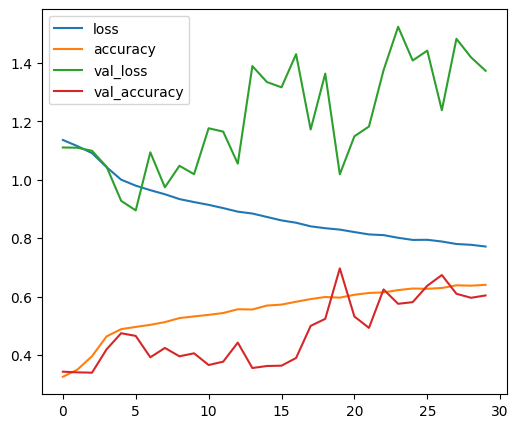

[[228  38  17]
 [113 114  79]
 [ 25  74 186]]


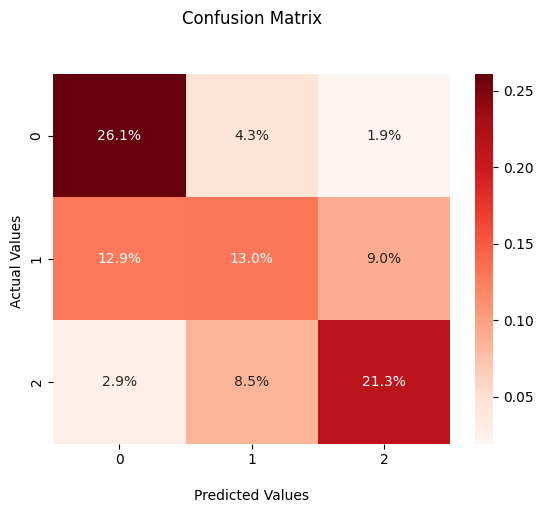

SUBJECT 12
7/7 [==============================] - 0s 6ms/step - loss: 0.9206 - accuracy: 0.4432
Score : loss of 0.9205769300460815; accuracy of 44.3155437707901%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.43129551064971616
Precision:  0.45663139605790315
Recall:  0.4431554524361949


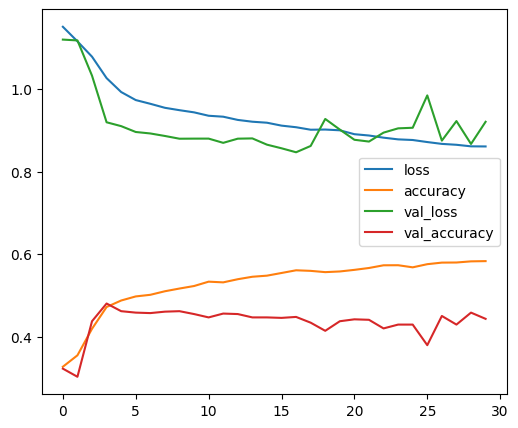

[[ 19 254   0]
 [ 92 169  30]
 [ 34  70 194]]


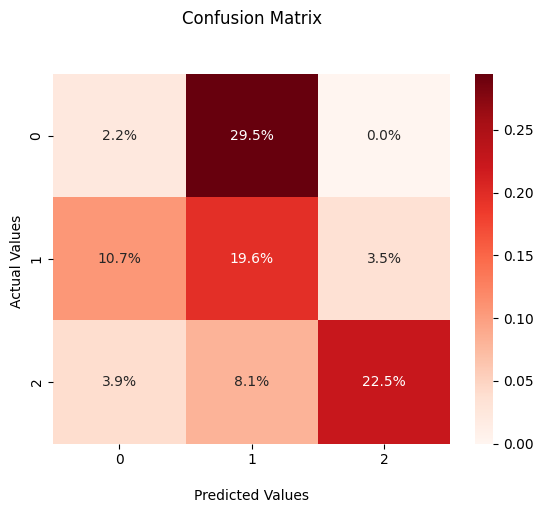

SUBJECT 13
7/7 [==============================] - 0s 6ms/step - loss: 1.1032 - accuracy: 0.4472
Score : loss of 1.1031750440597534; accuracy of 44.7247713804245%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.4292926500207752
Precision:  0.432482648479836
Recall:  0.44724770642201833


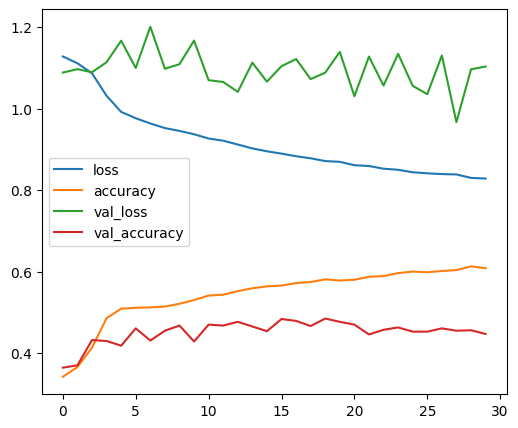

[[110  78 100]
 [ 82 220   0]
 [146  76  60]]


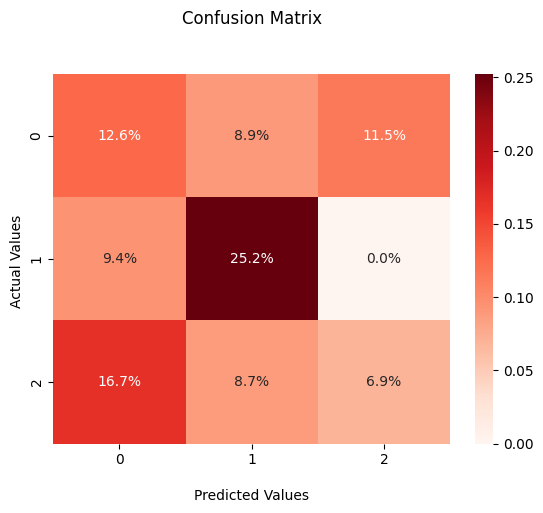

SUBJECT 14
7/7 [==============================] - 0s 6ms/step - loss: 1.1946 - accuracy: 0.4468
Score : loss of 1.1945825815200806; accuracy of 44.68085169792175%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.44635727299698275
Precision:  0.4742514241199669
Recall:  0.44680851063829785


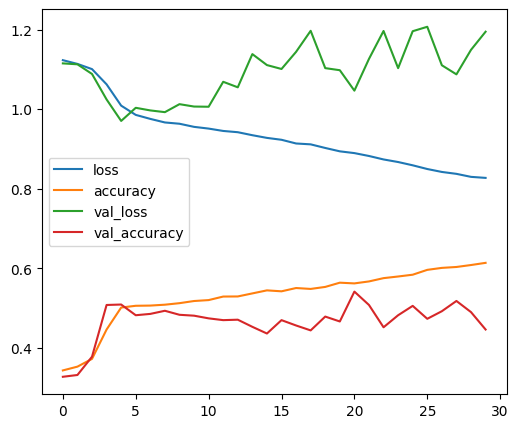

[[136 113  36]
 [109 155  36]
 [100 100 108]]


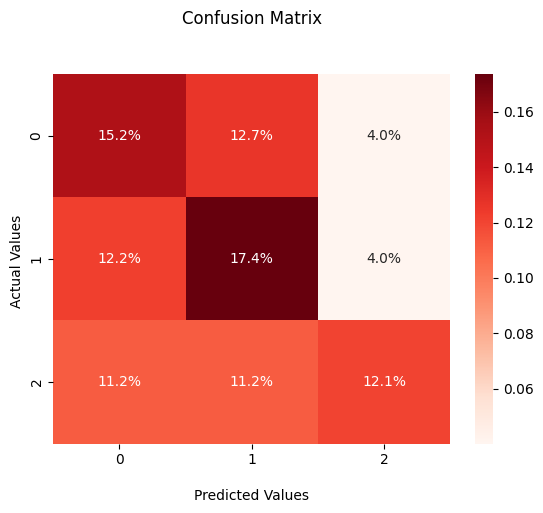

SUBJECT 15
7/7 [==============================] - 0s 6ms/step - loss: 1.2972 - accuracy: 0.3812
Score : loss of 1.2971699237823486; accuracy of 38.12282681465149%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.3452146984636043
Precision:  0.33973816672159113
Recall:  0.38122827346465815


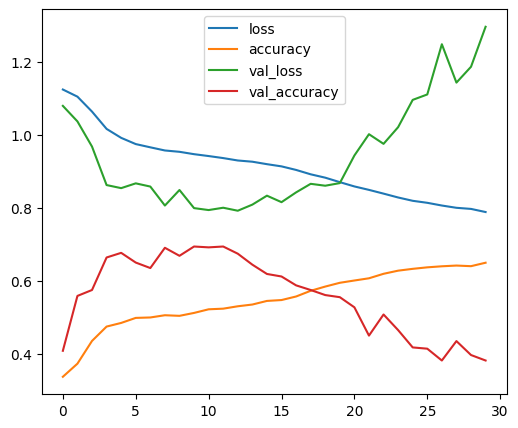

[[ 15  95 188]
 [ 73 124  90]
 [ 74  14 190]]


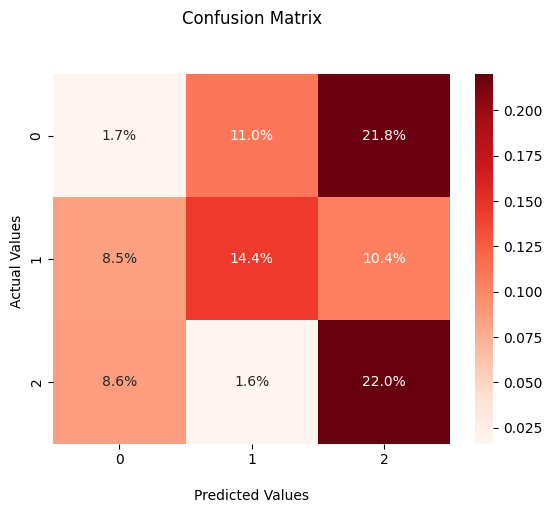

SUBJECT 16
7/7 [==============================] - 0s 6ms/step - loss: 1.5508 - accuracy: 0.3564
Score : loss of 1.550760269165039; accuracy of 35.64131557941437%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.27128811652175544
Precision:  0.23491292333913324
Recall:  0.3564131668558456


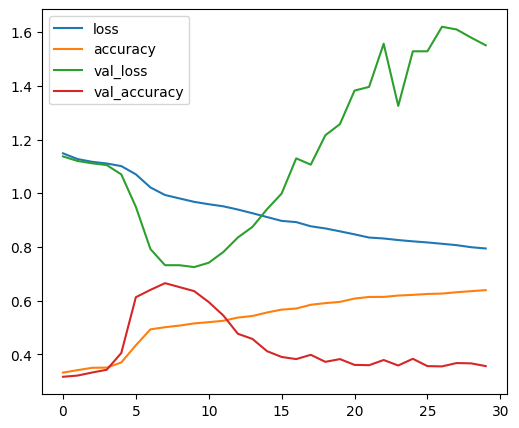

[[  1 298   1]
 [ 19  46 228]
 [  0  21 267]]


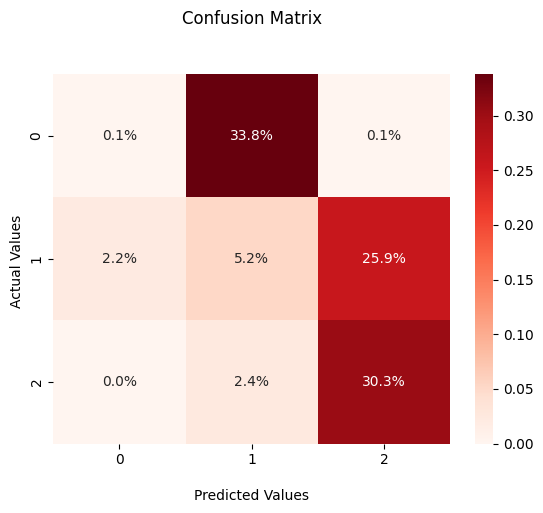

SUBJECT 17
7/7 [==============================] - 0s 6ms/step - loss: 1.7154 - accuracy: 0.3649
Score : loss of 1.715385913848877; accuracy of 36.4864856004715%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.28303908443592235
Precision:  0.31019266104947535
Recall:  0.36486486486486486


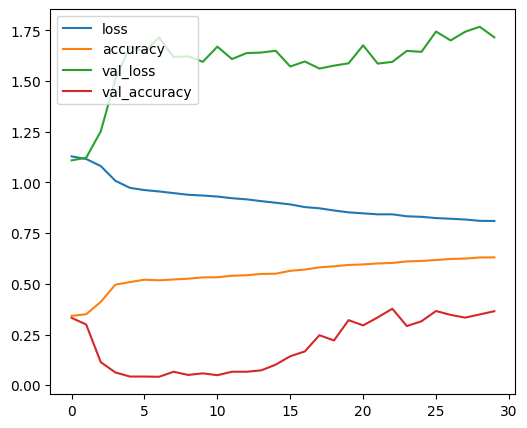

[[ 72  75 156]
 [ 27   1 270]
 [ 33   3 251]]


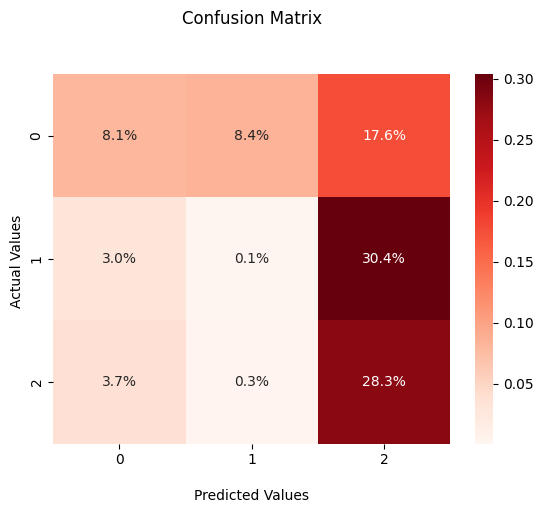

SUBJECT 18
7/7 [==============================] - 0s 6ms/step - loss: 0.8732 - accuracy: 0.4977
Score : loss of 0.873217761516571; accuracy of 49.772727489471436%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.4340114666797687
Precision:  0.4941871770334928
Recall:  0.49772727272727274


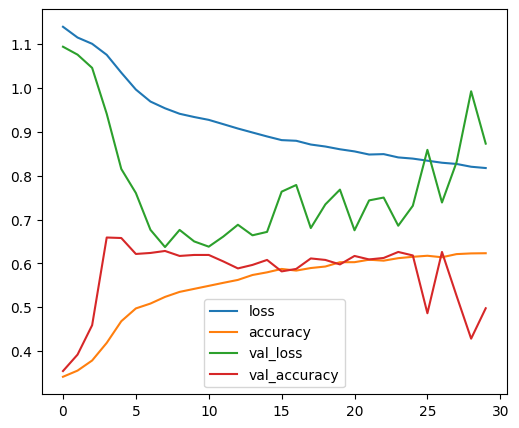

[[  4 296   0]
 [  0 293   0]
 [110  36 141]]


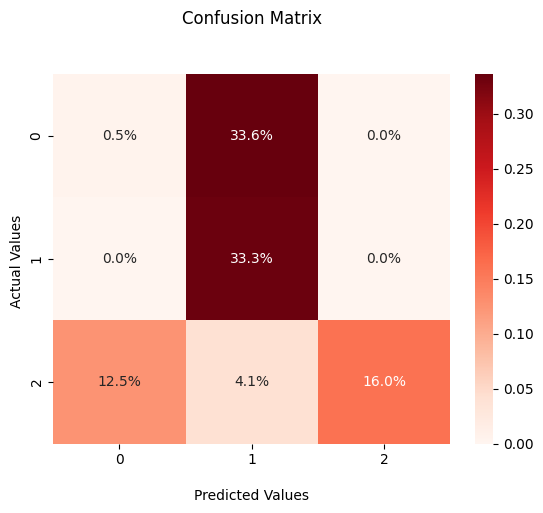

SUBJECT 19
7/7 [==============================] - 0s 6ms/step - loss: 0.6845 - accuracy: 0.6375
Score : loss of 0.6845380663871765; accuracy of 63.75291347503662%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.626359764850285
Precision:  0.6210075903443162
Recall:  0.6375291375291375


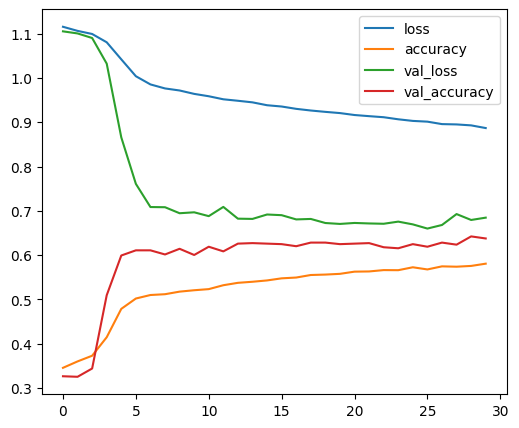

[[125  99  68]
 [127 162   0]
 [  0  17 260]]


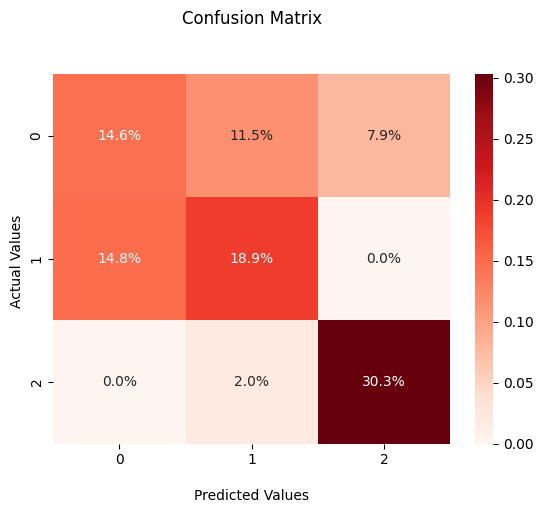

SUBJECT 20
7/7 [==============================] - 0s 6ms/step - loss: 1.1582 - accuracy: 0.3829
Score : loss of 1.158219337463379; accuracy of 38.28571438789368%
28/28 [==============================] - 0s 2ms/step
F1 score:  0.3805121383067355
Precision:  0.37864621715545077
Recall:  0.38285714285714284


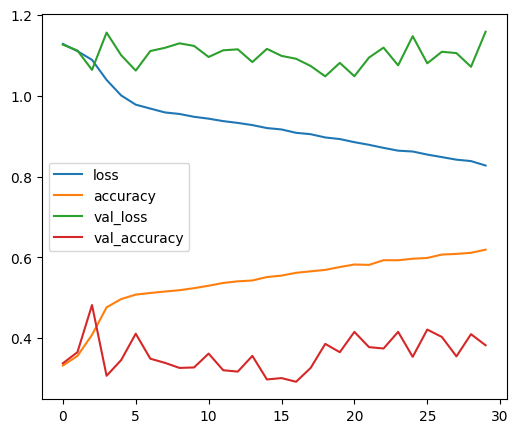

[[ 81 202  13]
 [ 67  90 130]
 [128   0 164]]


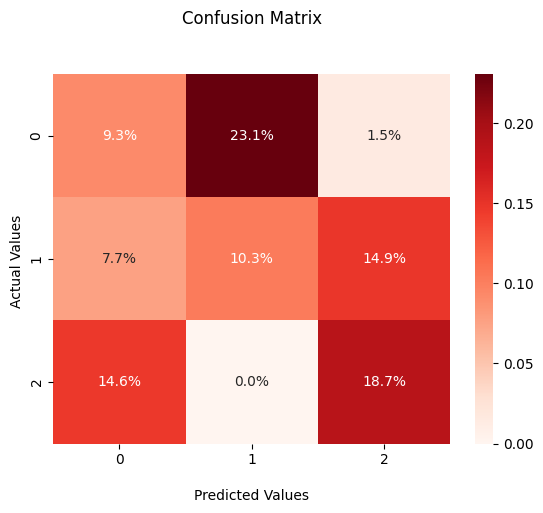

SUBJECT 21
7/7 [==============================] - 0s 6ms/step - loss: 1.7808 - accuracy: 0.3856
Score : loss of 1.7807819843292236; accuracy of 38.55981528759003%
27/27 [==============================] - 0s 2ms/step
F1 score:  0.3086740137777142
Precision:  0.32884672516593083
Recall:  0.38559814169570267


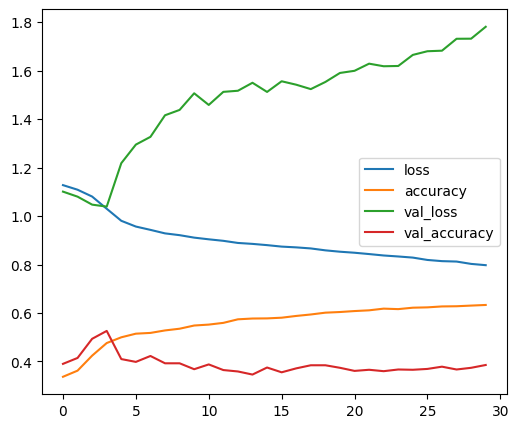

[[  8 140 142]
 [  0 236  53]
 [ 25 169  88]]


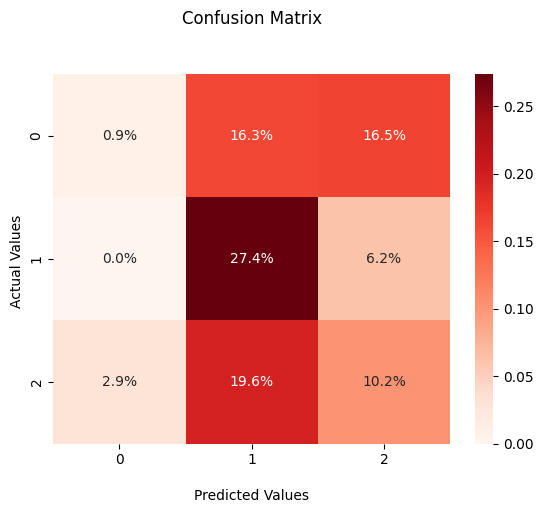

In [ ]:
from sklearn.model_selection import train_test_split

for sub in range(len(all_data)):

    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(test_data_all['data'], test_data_all['label'],
                                                                                 test_size=0.05, random_state=3456789)

    train_data, train_data_all = {}, {}
    test_data = {}
    
    train_data_all["data"] = np.concatenate([all_data[i]["data"] for i in range(len(all_data)) if i != sub])    
    train_data['data'] = np.concatenate((train_data_all['data'], X_test_split), axis=0)
    
    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split), axis=0)
    
    test_data['data'] = X_train_split
    test_data['label'] = y_train_split

    cm_w_ft_5, acc_w_ft_5, loss_w_ft_5, f1_w_ft_5, prec_w_ft_5, rec_w_ft_5 = transformers(train_data, test_data)

**Average accuracy and F1 score (5% ft)**

In [3]:
print(acc_w_ft_5)

[52.173912525177, 21.832579374313354, 46.697038412094116, 41.78082048892975, 19.770115613937378, 17.031070590019226, 38.25198709964752, 60.18306612968445, 58.09859037399292, 66.74338579177856, 47.42041826248169, 60.41190028190613, 44.3155437707901, 44.7247713804245, 44.68085169792175, 38.12282681465149, 35.64131557941437, 36.4864856004715, 49.772727489471436, 63.75291347503662, 38.28571438789368, 38.55981528759003]


In [5]:
print((acc_w_ft_5))
print((f1_w_ft_5))

43.85172047398307
0.4000336571354687


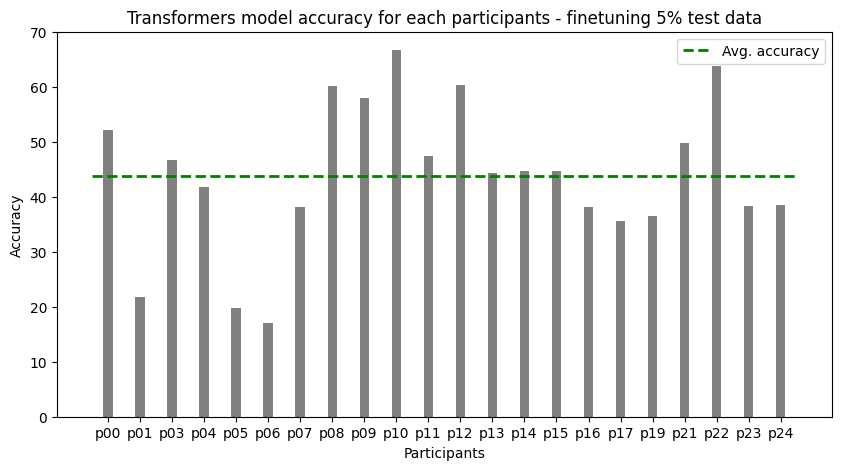

In [9]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_5, color ='grey',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Transformers model accuracy for each participants - finetuning 5% test data")

plt.hlines(y=(np.mean(acc_w_ft_5)), xmin=-0.5, xmax=(len(acc_w_ft_5)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

# **Finetuning 10% of test data (LOSO)**

SUBJECT 0
7/7 [==============================] - 0s 6ms/step - loss: 0.8398 - accuracy: 0.6111
Score : loss of 0.8398453593254089; accuracy of 61.11111044883728%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.5412447627344277
Precision:  0.6308628957319004
Recall:  0.6111111111111112


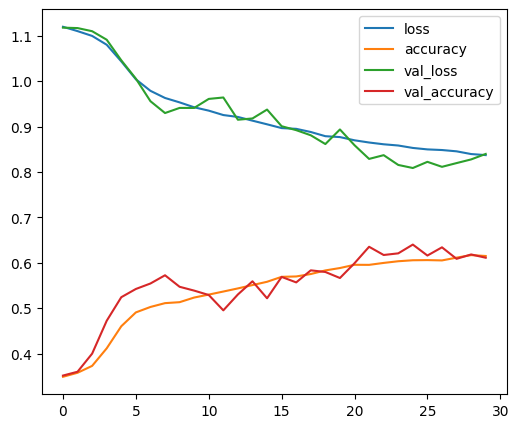

[[ 32  71 181]
 [ 19 224  42]
 [  1   8 250]]


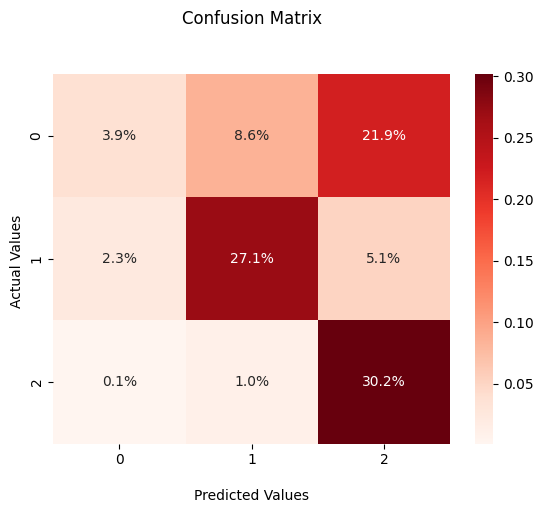

SUBJECT 1
7/7 [==============================] - 0s 6ms/step - loss: 2.6329 - accuracy: 0.1278
Score : loss of 2.6329121589660645; accuracy of 12.783750891685486%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.12311423653475428
Precision:  0.1700691109603183
Recall:  0.12783751493428913


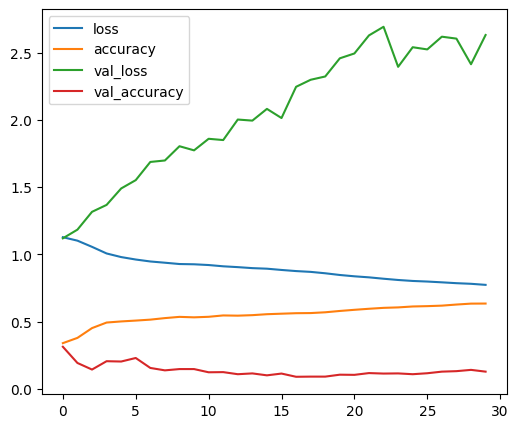

[[ 19  66 188]
 [ 26  88 173]
 [ 19 258   0]]


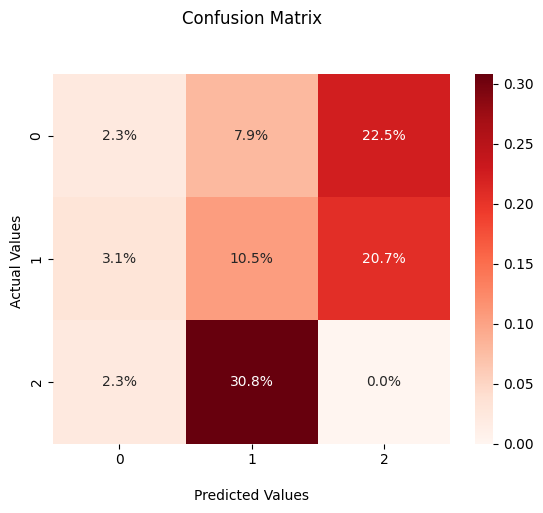

SUBJECT 2
7/7 [==============================] - 0s 6ms/step - loss: 1.5138 - accuracy: 0.3810
Score : loss of 1.5138335227966309; accuracy of 38.10096085071564%
26/26 [==============================] - 0s 2ms/step
F1 score:  0.3494474735081508
Precision:  0.3865548744517169
Recall:  0.38100961538461536


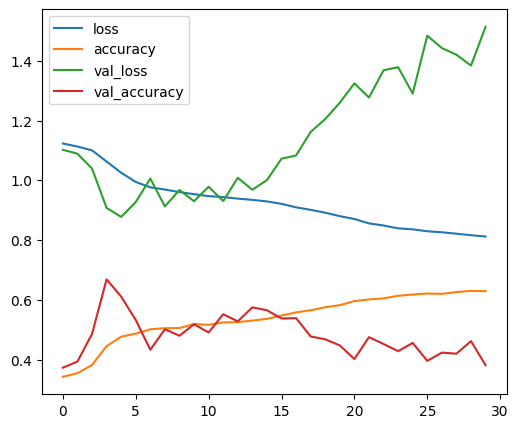

[[ 77  23 182]
 [ 26 221  32]
 [ 26 226  19]]


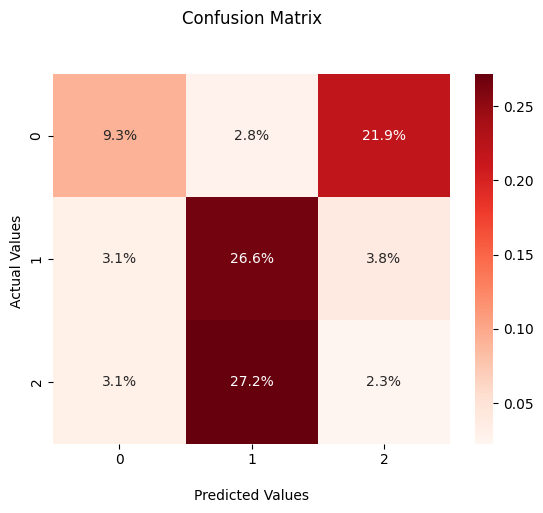

SUBJECT 3
7/7 [==============================] - 0s 6ms/step - loss: 0.9840 - accuracy: 0.5470
Score : loss of 0.9839974641799927; accuracy of 54.69879508018494%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.5062657181129574
Precision:  0.49641790365169153
Recall:  0.5469879518072289


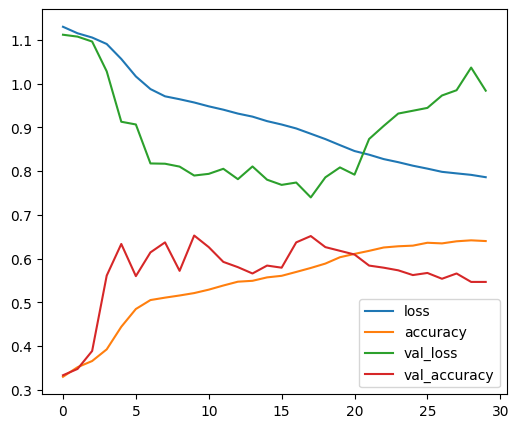

[[ 37  77 156]
 [ 64 223   3]
 [ 24  52 194]]


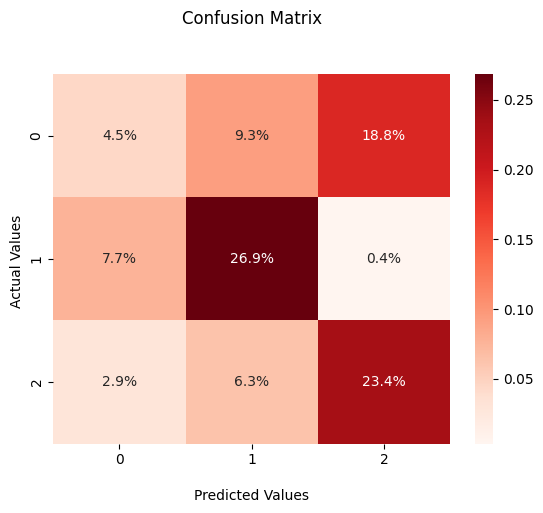

SUBJECT 4
7/7 [==============================] - 0s 7ms/step - loss: 2.2615 - accuracy: 0.2743
Score : loss of 2.261486053466797; accuracy of 27.427184581756592%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.24163568212905398
Precision:  0.24208299371526648
Recall:  0.27427184466019416


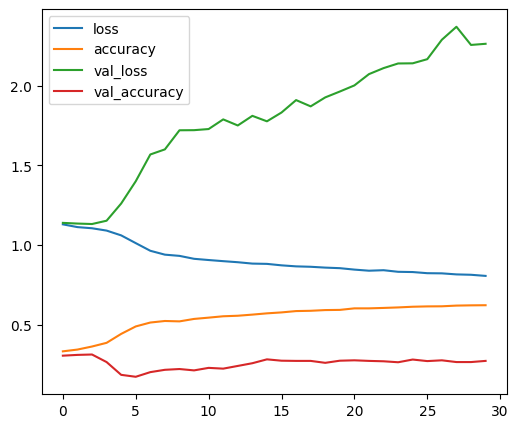

[[ 57 125  86]
 [ 19 167 100]
 [ 82 186   2]]


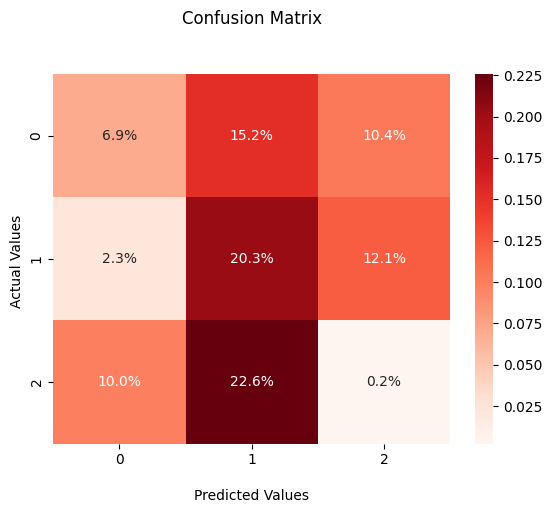

SUBJECT 5
7/7 [==============================] - 0s 6ms/step - loss: 1.8512 - accuracy: 0.4241
Score : loss of 1.8511649370193481; accuracy of 42.405831813812256%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.3666253765140447
Precision:  0.32698716362530633
Recall:  0.4240583232077764


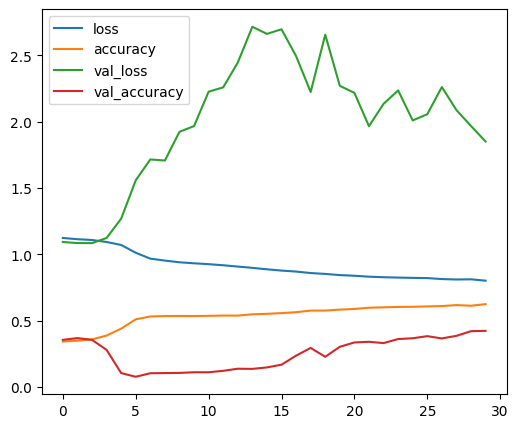

[[  0  52 215]
 [ 61 184  43]
 [ 17  86 165]]


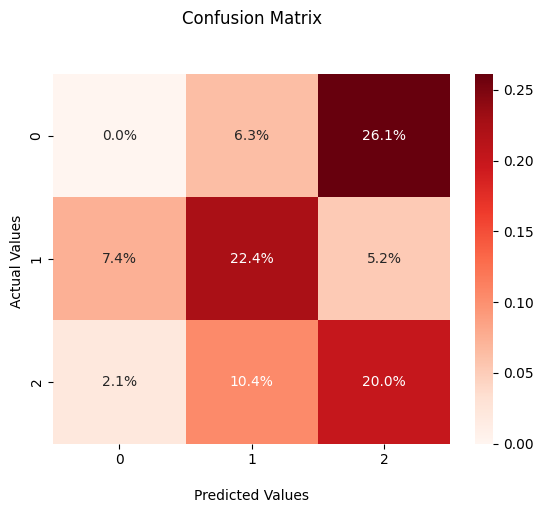

SUBJECT 6
7/7 [==============================] - 0s 6ms/step - loss: 1.2608 - accuracy: 0.3521
Score : loss of 1.2608410120010376; accuracy of 35.20958125591278%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.30888773171122647
Precision:  0.2941171063979585
Recall:  0.3520958083832335


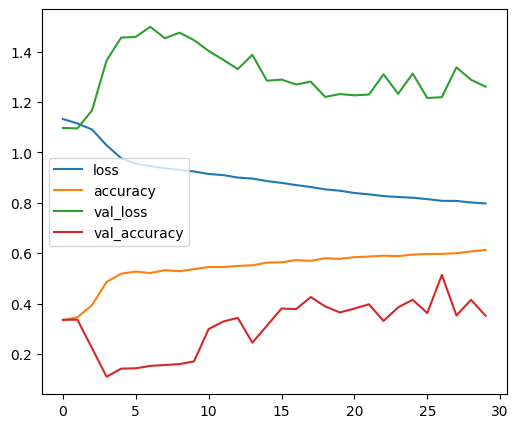

[[  4 180  90]
 [ 54 199  32]
 [ 93  92  91]]


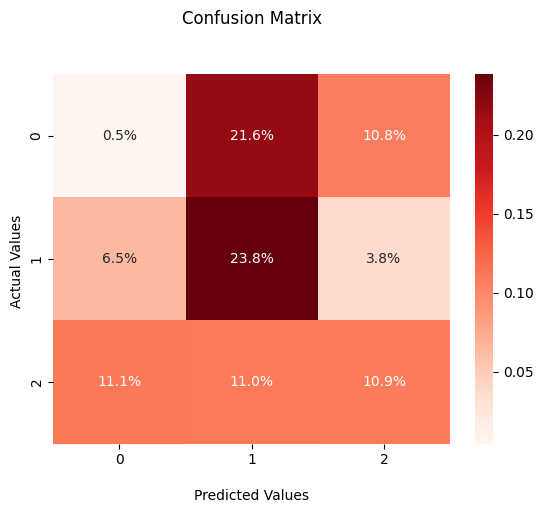

SUBJECT 7
7/7 [==============================] - 0s 6ms/step - loss: 0.8633 - accuracy: 0.5229
Score : loss of 0.8633487820625305; accuracy of 52.2946834564209%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.5313511968488784
Precision:  0.5783235434050651
Recall:  0.5229468599033816


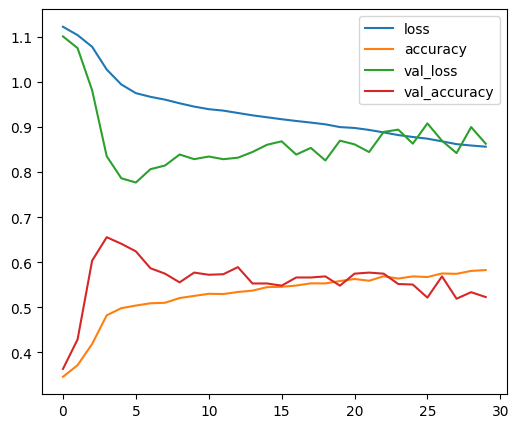

[[ 73 211   0]
 [112 164   0]
 [  7  65 196]]


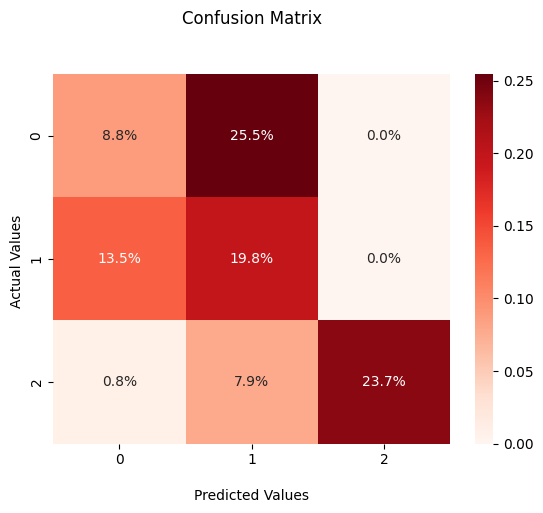

SUBJECT 8
7/7 [==============================] - 0s 6ms/step - loss: 1.1397 - accuracy: 0.3779
Score : loss of 1.1396795511245728; accuracy of 37.79430091381073%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.2625098252456965
Precision:  0.3435964538242244
Recall:  0.37794299876084264


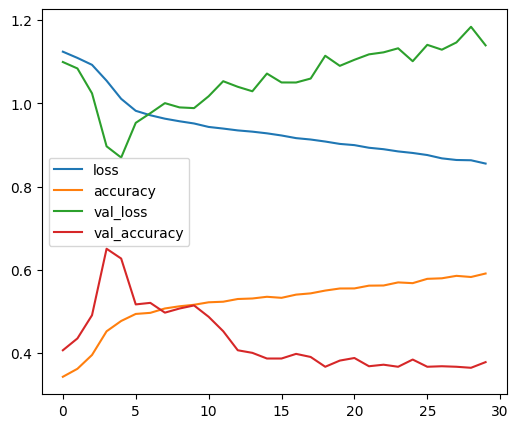

[[ 17 168  85]
 [  2 274   4]
 [ 17 226  14]]


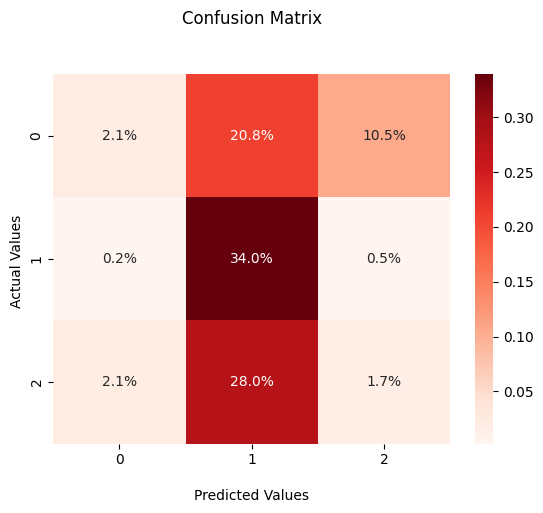

SUBJECT 9
7/7 [==============================] - 0s 7ms/step - loss: 0.7629 - accuracy: 0.7327
Score : loss of 0.7629154324531555; accuracy of 73.26852679252625%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.714713886247158
Precision:  0.7438740819114721
Recall:  0.732685297691373


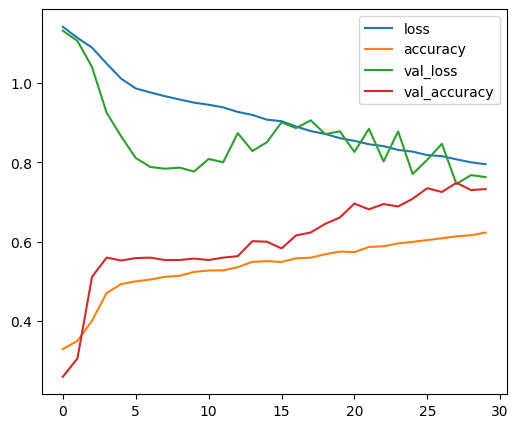

[[118  85  66]
 [  8 284   0]
 [ 25  36 201]]


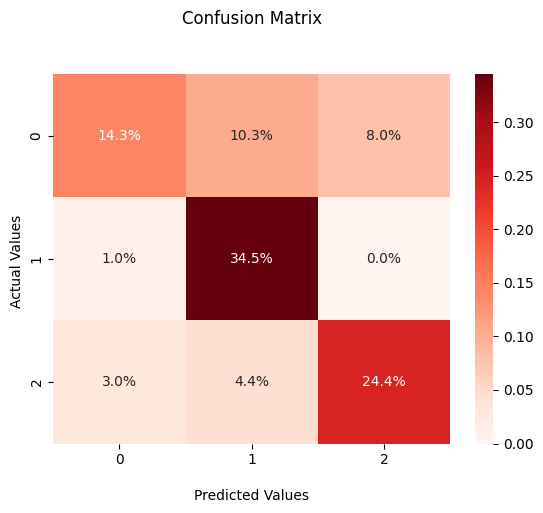

SUBJECT 10
7/7 [==============================] - 0s 7ms/step - loss: 1.5541 - accuracy: 0.4392
Score : loss of 1.5540649890899658; accuracy of 43.91657114028931%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.3818066037615756
Precision:  0.36080631985778344
Recall:  0.4391657010428737


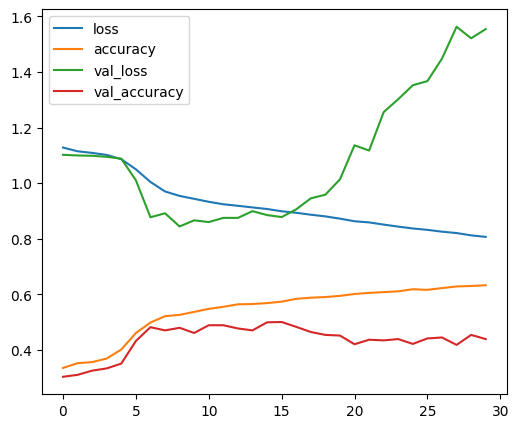

[[ 10 278   1]
 [ 49 124 122]
 [ 16  18 245]]


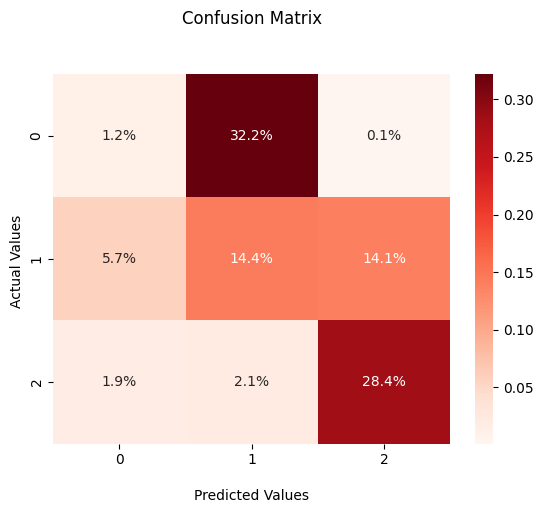

SUBJECT 11
7/7 [==============================] - 0s 6ms/step - loss: 1.7223 - accuracy: 0.3635
Score : loss of 1.7223436832427979; accuracy of 36.35265827178955%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.31491742294608954
Precision:  0.31233207292133414
Recall:  0.3635265700483092


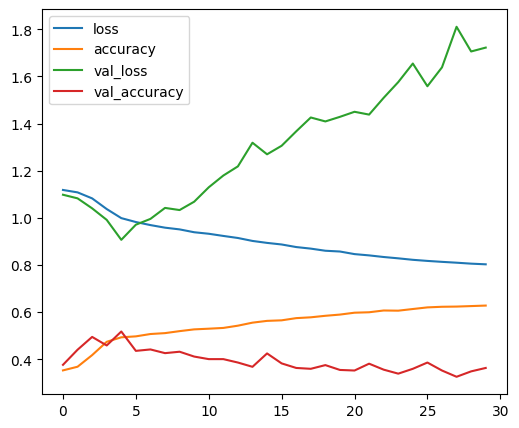

[[  6 258   0]
 [ 20 108 162]
 [ 13  74 187]]


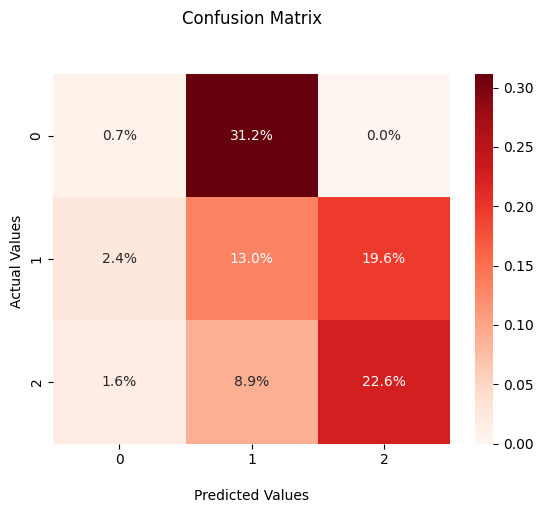

SUBJECT 12
7/7 [==============================] - 0s 6ms/step - loss: 1.0034 - accuracy: 0.5802
Score : loss of 1.003400444984436; accuracy of 58.01713466644287%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.5915513537634628
Precision:  0.6285632884729494
Recall:  0.5801713586291309


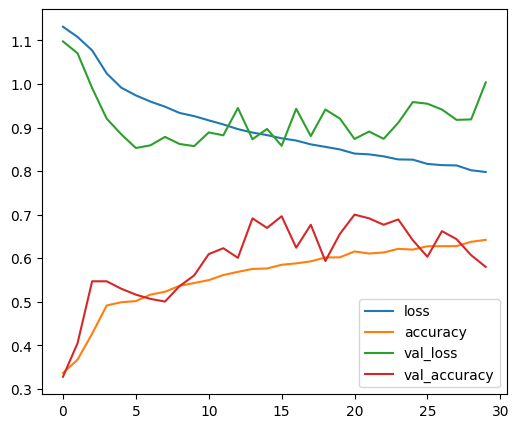

[[170  85   0]
 [147 121  11]
 [ 15  85 183]]


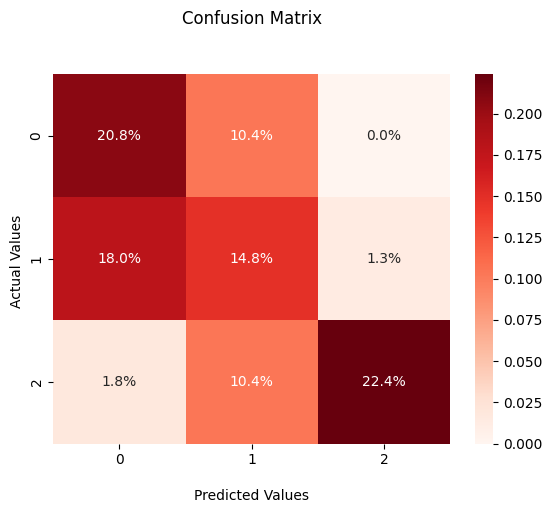

SUBJECT 13
7/7 [==============================] - 0s 6ms/step - loss: 0.9925 - accuracy: 0.4855
Score : loss of 0.9924664497375488; accuracy of 48.54721426963806%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.4281163154374166
Precision:  0.4343186119177684
Recall:  0.4854721549636804


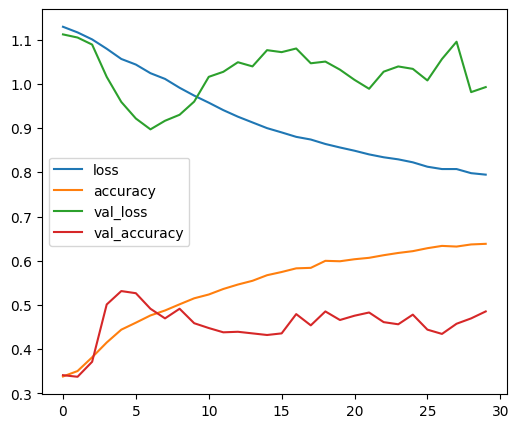

[[ 55 132  90]
 [  0 280   0]
 [123  80  66]]


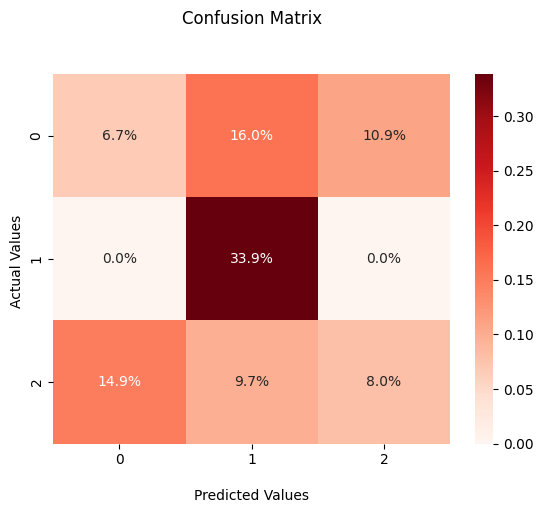

SUBJECT 14
7/7 [==============================] - 0s 8ms/step - loss: 1.4252 - accuracy: 0.3416
Score : loss of 1.4252293109893799; accuracy of 34.160757064819336%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.34287747561998216
Precision:  0.3813908551776278
Recall:  0.3416075650118203


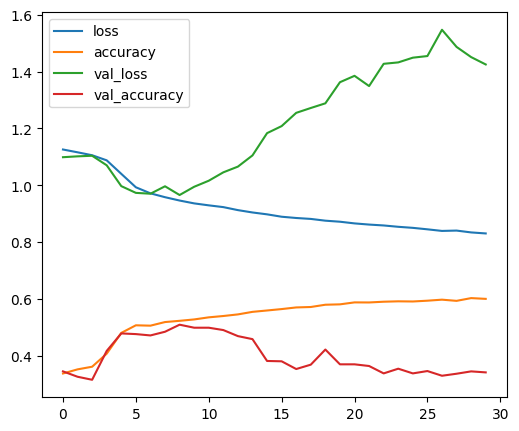

[[ 68 201   0]
 [ 82 131  72]
 [ 89 113  90]]


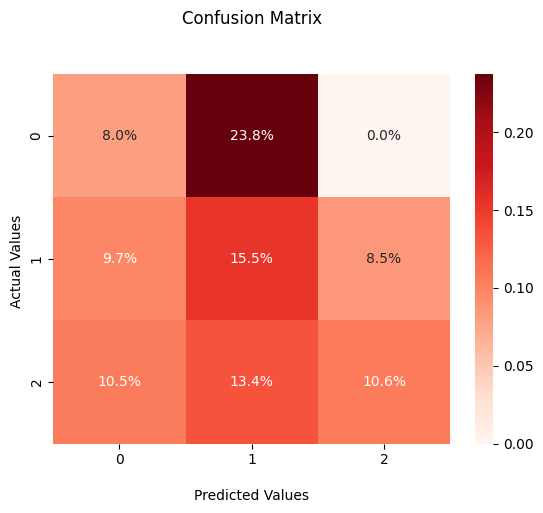

SUBJECT 15
7/7 [==============================] - 0s 6ms/step - loss: 0.9564 - accuracy: 0.5391
Score : loss of 0.9563683867454529; accuracy of 53.911978006362915%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.4947131553911064
Precision:  0.672464496224273
Recall:  0.539119804400978


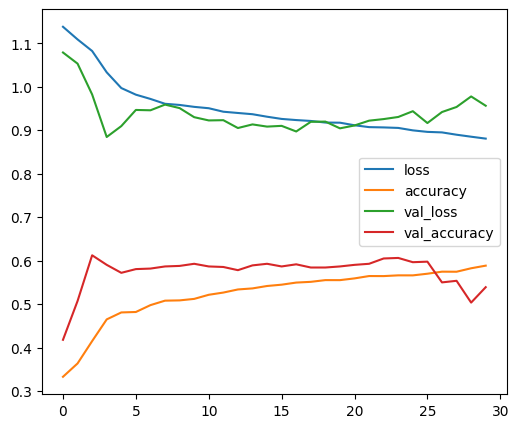

[[178 107   0]
 [ 49 224   0]
 [187  34  39]]


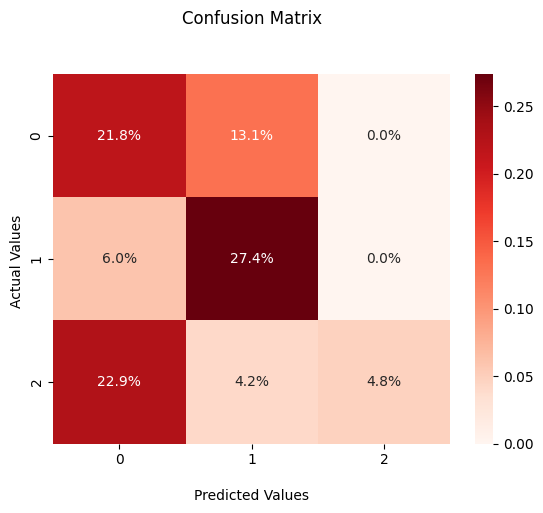

SUBJECT 16
7/7 [==============================] - 0s 7ms/step - loss: 0.9533 - accuracy: 0.4515
Score : loss of 0.9533262848854065; accuracy of 45.149701833724976%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.4360759784162444
Precision:  0.4325898791057431
Recall:  0.45149700598802395


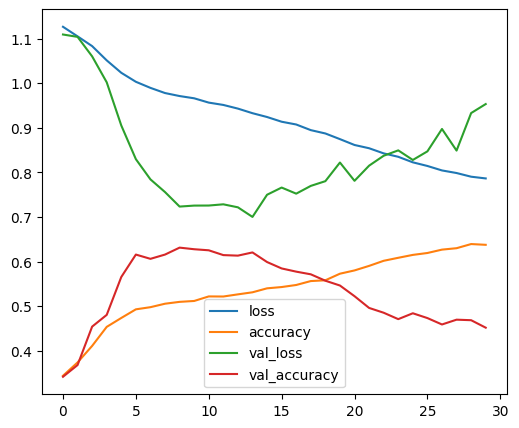

[[ 16 272   0]
 [152 116  12]
 [  1  21 245]]


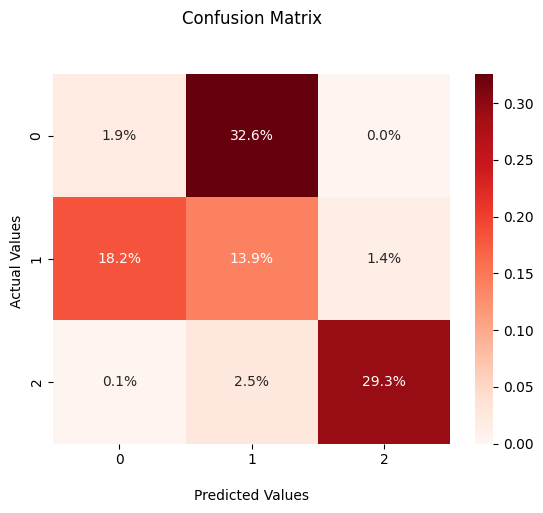

SUBJECT 17
7/7 [==============================] - 0s 6ms/step - loss: 1.6544 - accuracy: 0.2866
Score : loss of 1.654447078704834; accuracy of 28.656360507011414%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.2805152904514853
Precision:  0.2848997727255255
Recall:  0.28656361474435194


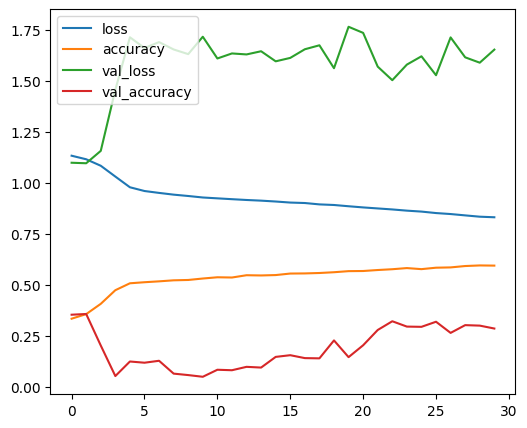

[[ 60  58 170]
 [ 70 134  78]
 [ 64 160  47]]


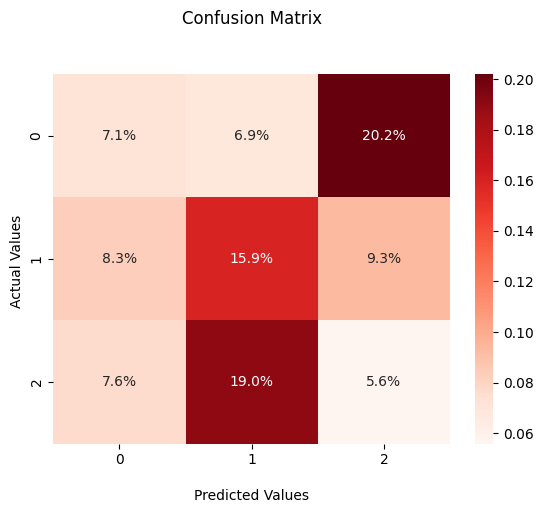

SUBJECT 18
7/7 [==============================] - 0s 6ms/step - loss: 0.8394 - accuracy: 0.5324
Score : loss of 0.8394001126289368; accuracy of 53.23740839958191%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.5275800772021788
Precision:  0.5279254444694186
Recall:  0.5323741007194245


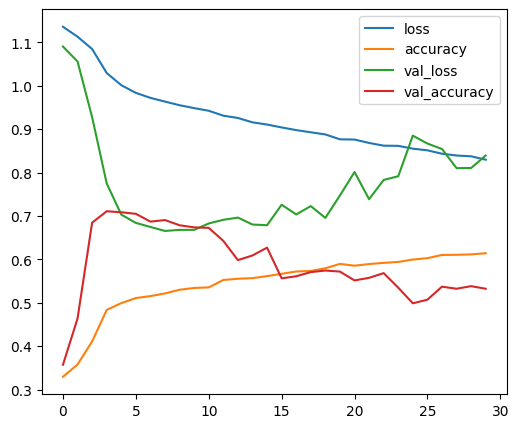

[[126 145  15]
 [201  71   8]
 [ 17   4 247]]


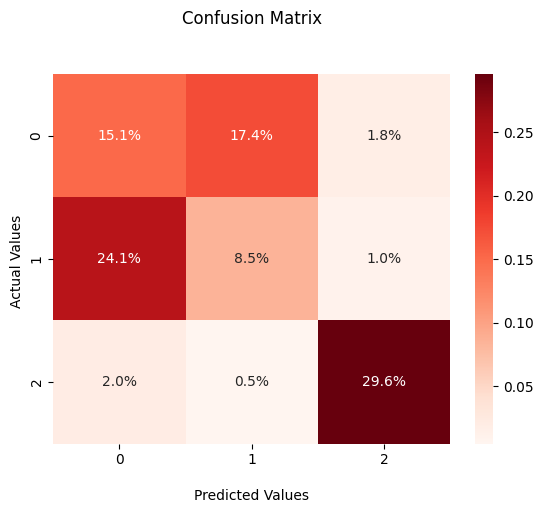

SUBJECT 19
7/7 [==============================] - 0s 6ms/step - loss: 0.7113 - accuracy: 0.5326
Score : loss of 0.7113181948661804; accuracy of 53.259533643722534%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.520115649374835
Precision:  0.52021671028143
Recall:  0.5325953259532595


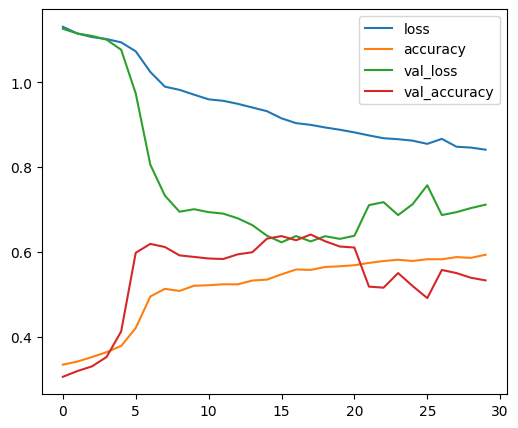

[[ 57 214   7]
 [125 131  18]
 [  2  14 245]]


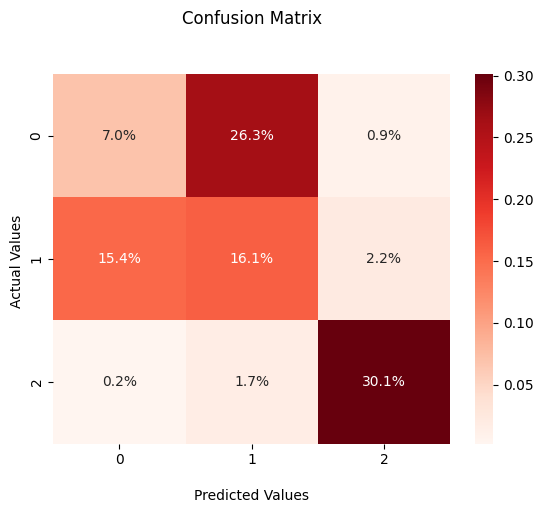

SUBJECT 20
7/7 [==============================] - 0s 7ms/step - loss: 1.4412 - accuracy: 0.4379
Score : loss of 1.4412223100662231; accuracy of 43.787696957588196%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.3537904330107902
Precision:  0.4567013323542511
Recall:  0.4378769601930036


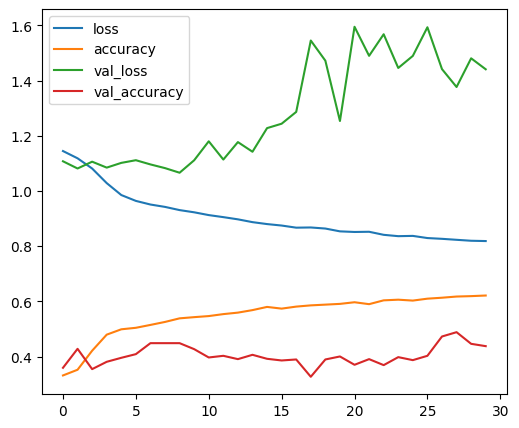

[[  1 273   5]
 [  0 271   0]
 [ 63 125  91]]


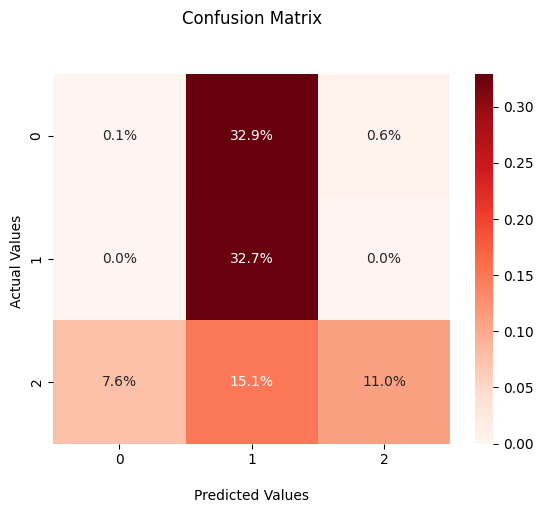

SUBJECT 21
7/7 [==============================] - 0s 7ms/step - loss: 1.4413 - accuracy: 0.3603
Score : loss of 1.441269874572754; accuracy of 36.02941036224365%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.2634653583777298
Precision:  0.26993760138769063
Recall:  0.3602941176470588


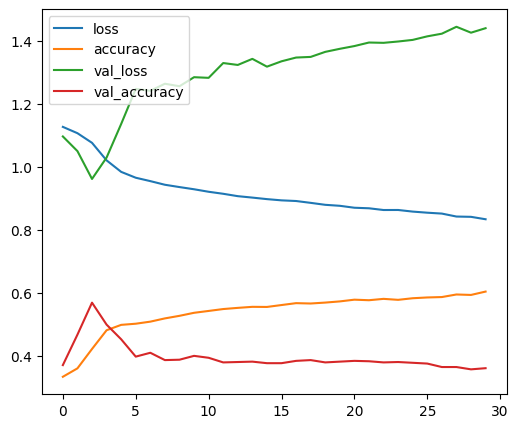

[[  9 142 124]
 [ 19 250   5]
 [ 22 210  35]]


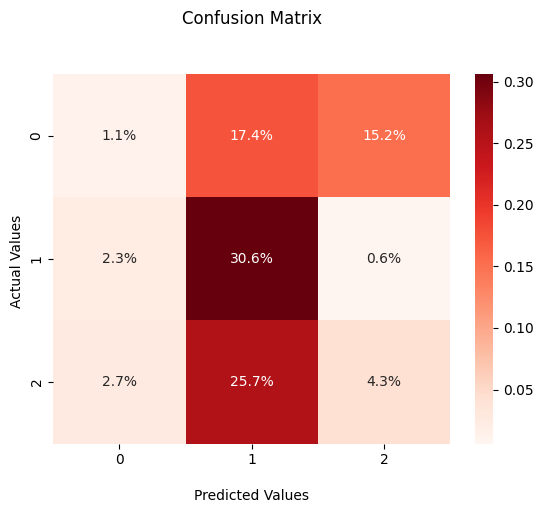

In [ ]:
from sklearn.model_selection import train_test_split

for sub in range(len(all_data)):

    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(test_data_all['data'], test_data_all['label'],
                                                                                 test_size=0.1, random_state=3456789)

    train_data, train_data_all = {}, {}
    test_data = {}
    
    train_data_all["data"] = np.concatenate([all_data[i]["data"] for i in range(len(all_data)) if i != sub])    
    train_data['data'] = np.concatenate((train_data_all['data'], X_test_split), axis=0)
    
    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split), axis=0)
    
    test_data['data'] = X_train_split
    test_data['label'] = y_train_split

    cm_w_ft_10, acc_w_ft_10, loss_w_ft_10, f1_w_ft_10, prec_w_ft_10, rec_w_ft_10 = transformers(train_data, test_data)

**Average accuracy and F1 score (10% ft)**

In [11]:
print(acc_w_ft_10)

[61.11111044883728, 12.783750891685486, 38.10096085071564, 54.69879508018494, 27.427184581756592, 42.405831813812256, 35.20958125591278, 52.2946834564209, 37.79430091381073, 73.26852679252625, 43.91657114028931, 36.35265827178955, 58.01713466644287, 48.54721426963806, 48.54721426963806, 53.911978006362915, 45.149701833724976, 28.656360507011414, 53.23740839958191, 53.259533643722534, 43.787696957588196, 36.02941036224365]


In [10]:
print(np.mean(acc_w_ft_10))
print(np.mean(f1_w_ft_10))

44.096415964039885
0.40369640924269296


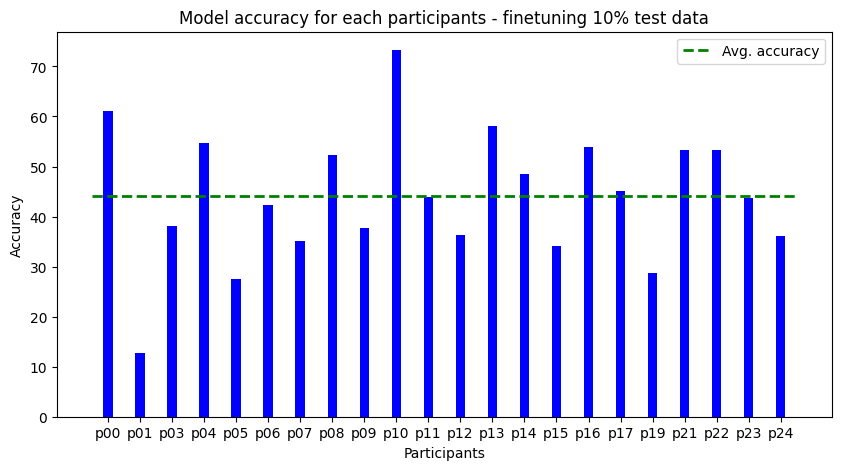

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_10, color ='blue',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 10% test data")

plt.hlines(y=(np.mean(acc_w_ft_10)), xmin=-0.5, xmax=(len(f1_w_ft_10)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

# **Finetuning 20% of test data (LOSO)**

SUBJECT 0
6/6 [==============================] - 0s 6ms/step - loss: 0.9298 - accuracy: 0.5109
Score : loss of 0.9298129677772522; accuracy of 51.0869562625885%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.42143331572404646
Precision:  0.45440992701981525
Recall:  0.5108695652173914


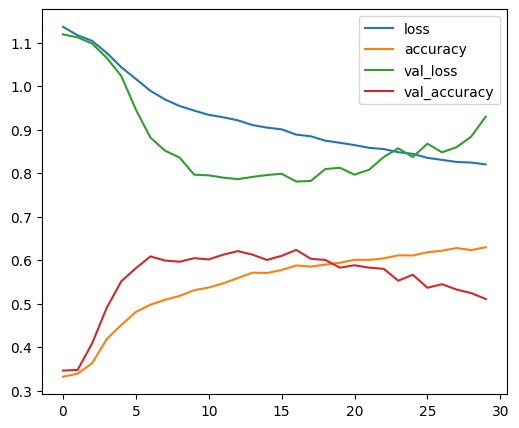

[[ 10 170  72]
 [  0 251   0]
 [ 27  91 115]]


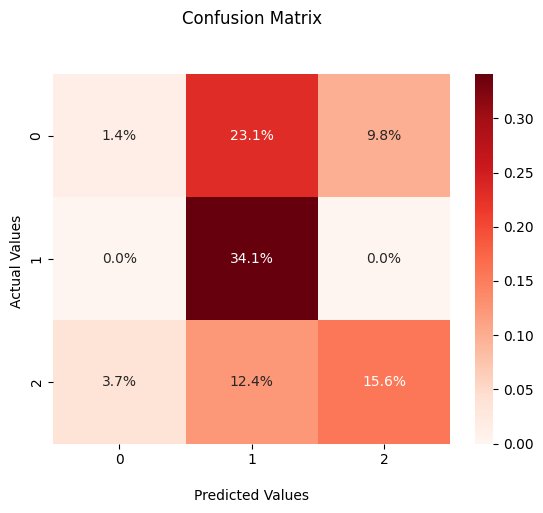

SUBJECT 1
6/6 [==============================] - 0s 7ms/step - loss: 2.0794 - accuracy: 0.2204
Score : loss of 2.0794308185577393; accuracy of 22.043010592460632%
24/24 [==============================] - 0s 2ms/step
F1 score:  0.17238646636216573
Precision:  0.1778597952060903
Recall:  0.22043010752688172


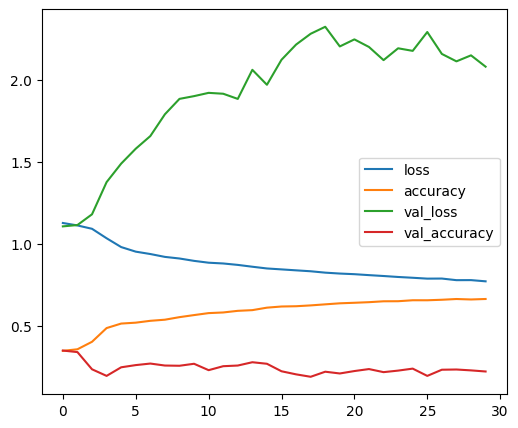

[[ 23 113 110]
 [ 70 141  42]
 [  0 245   0]]


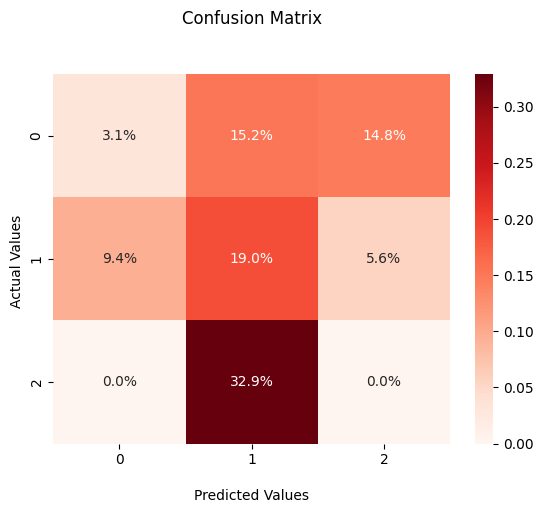

SUBJECT 2
6/6 [==============================] - 0s 6ms/step - loss: 1.1239 - accuracy: 0.5351
Score : loss of 1.123860239982605; accuracy of 53.51351499557495%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.5004490417923253
Precision:  0.6948337050905604
Recall:  0.5351351351351351


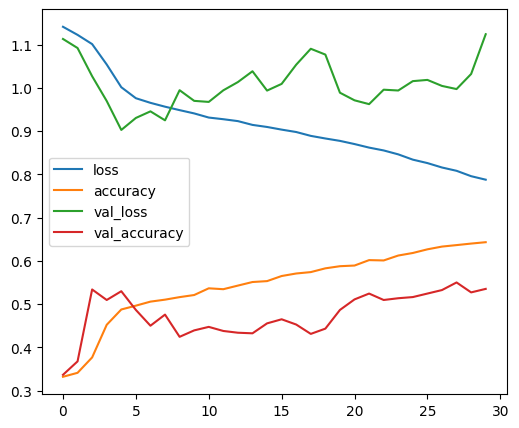

[[ 44 204   0]
 [  7 238   0]
 [ 16 117 114]]


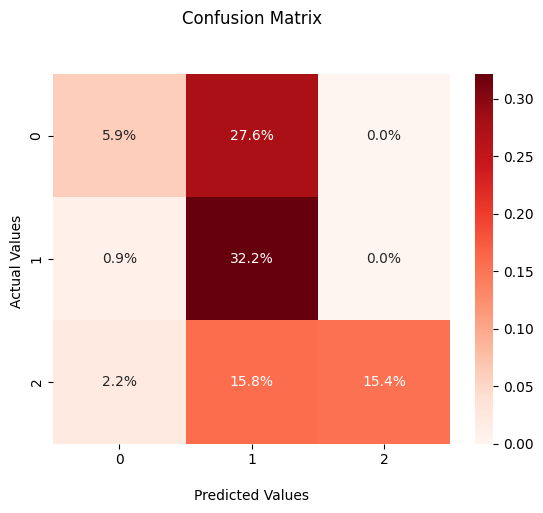

SUBJECT 3
6/6 [==============================] - 0s 7ms/step - loss: 1.0138 - accuracy: 0.5068
Score : loss of 1.0137957334518433; accuracy of 50.67750811576843%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.44197944797035965
Precision:  0.461345859056321
Recall:  0.5067750677506775


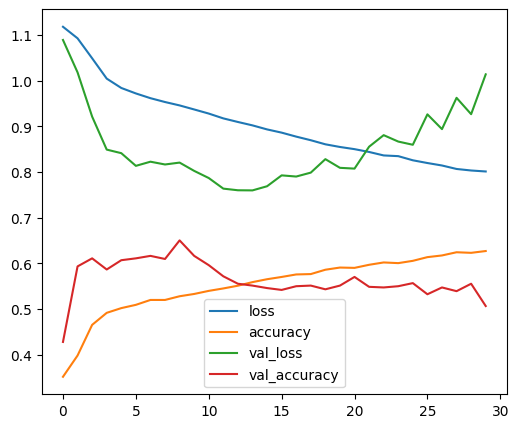

[[  0 248   1]
 [ 28 223   0]
 [ 20  67 151]]


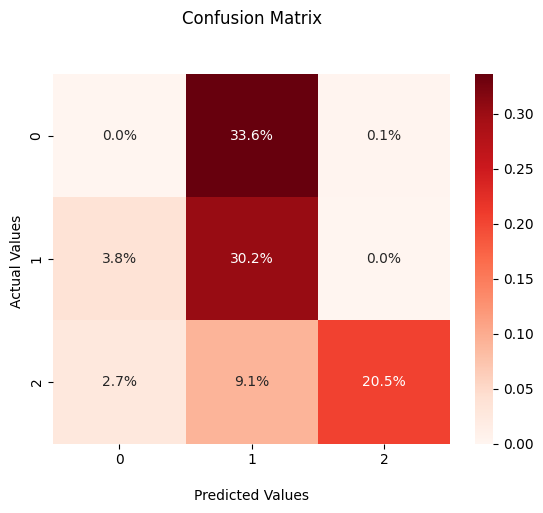

SUBJECT 4
6/6 [==============================] - 0s 7ms/step - loss: 2.4483 - accuracy: 0.1844
Score : loss of 2.4483232498168945; accuracy of 18.44262331724167%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.18460679271459904
Precision:  0.18738536161716138
Recall:  0.18442622950819673


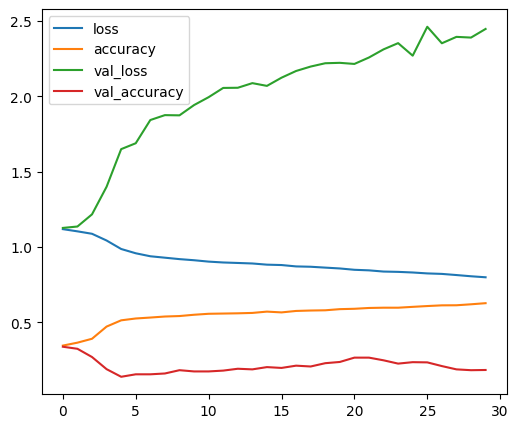

[[ 48  60 133]
 [ 28  87 130]
 [117 129   0]]


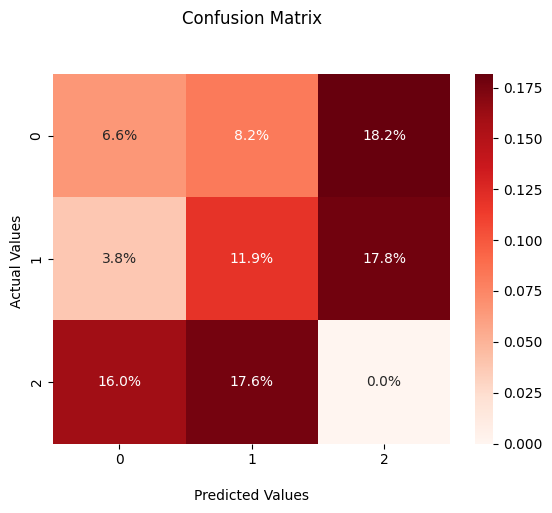

SUBJECT 5
6/6 [==============================] - 0s 7ms/step - loss: 1.5370 - accuracy: 0.2145
Score : loss of 1.5370409488677979; accuracy of 21.448087692260742%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.2091595107988551
Precision:  0.20409863497706676
Recall:  0.21448087431693988


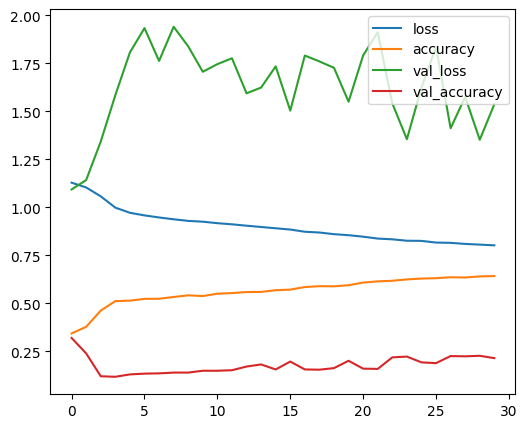

[[ 14  45 182]
 [ 63 143  41]
 [172  72   0]]


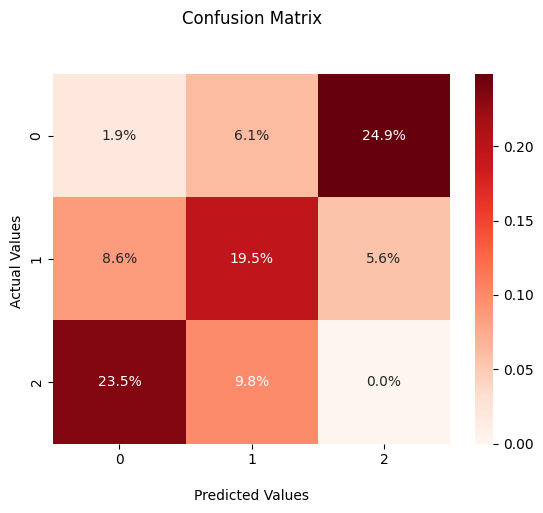

SUBJECT 6
6/6 [==============================] - 0s 6ms/step - loss: 1.1828 - accuracy: 0.4299
Score : loss of 1.1827704906463623; accuracy of 42.99191236495972%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.38915809180532845
Precision:  0.3670778150852253
Recall:  0.4299191374663073


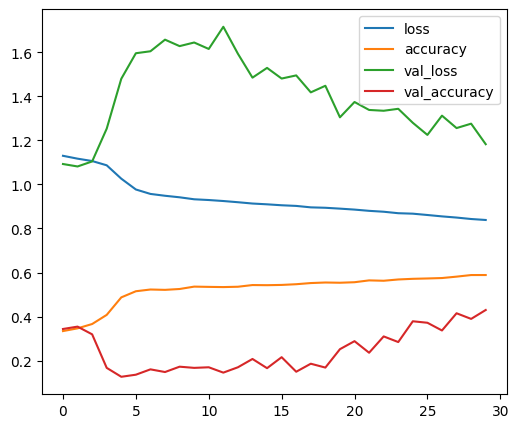

[[ 16 136 100]
 [ 11 167  71]
 [ 93  12 136]]


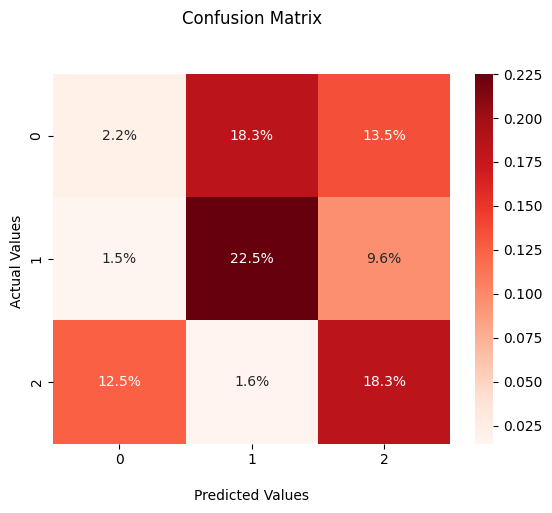

SUBJECT 7
6/6 [==============================] - 0s 7ms/step - loss: 0.8226 - accuracy: 0.7106
Score : loss of 0.8225709795951843; accuracy of 71.0597813129425%
23/23 [==============================] - 0s 2ms/step
F1 score:  0.7114635327073013
Precision:  0.7212678664748001
Recall:  0.7105978260869565


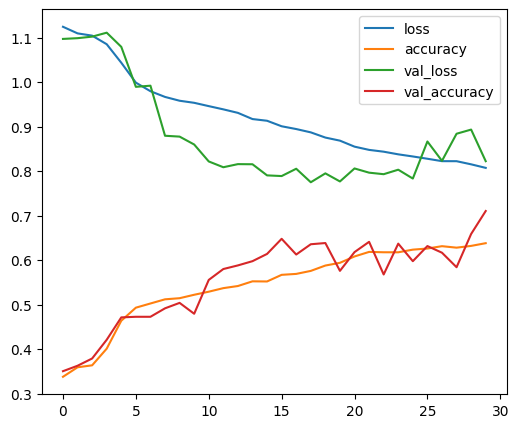

[[196  33  20]
 [ 73 157  14]
 [ 34  39 170]]


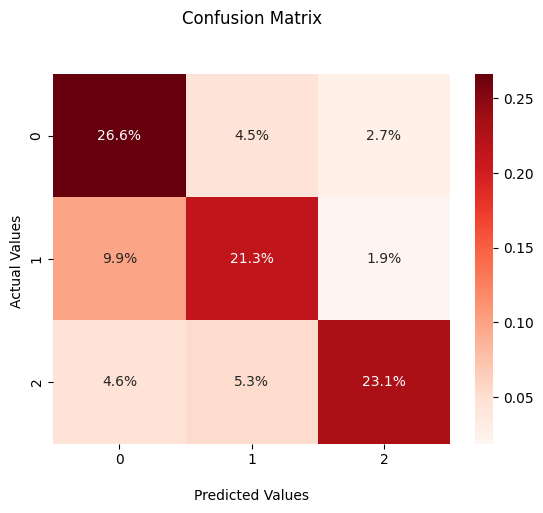

SUBJECT 8
6/6 [==============================] - 0s 6ms/step - loss: 1.1016 - accuracy: 0.4365
Score : loss of 1.101580262184143; accuracy of 43.65411400794983%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.3852253484110175
Precision:  0.5716191696718936
Recall:  0.43654114365411434


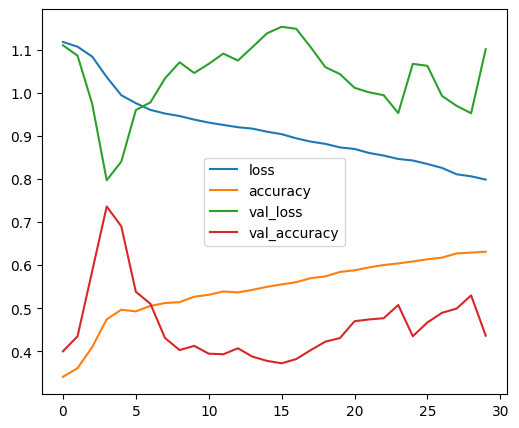

[[ 30 205   6]
 [ 23 216   3]
 [ 11 156  67]]


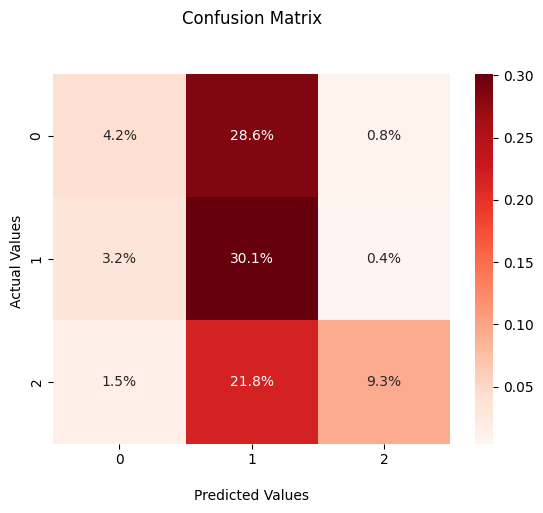

SUBJECT 9
6/6 [==============================] - 0s 6ms/step - loss: 0.9739 - accuracy: 0.4945
Score : loss of 0.9739335775375366; accuracy of 49.453550577163696%
23/23 [==============================] - 0s 2ms/step
F1 score:  0.47789895304240126
Precision:  0.5878701659811767
Recall:  0.49453551912568305


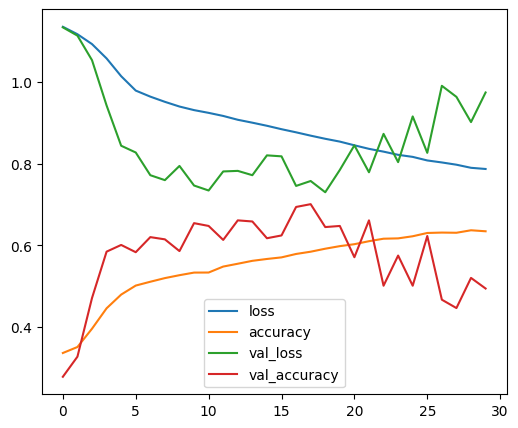

[[ 55 190   0]
 [ 42 209   0]
 [ 65  73  98]]


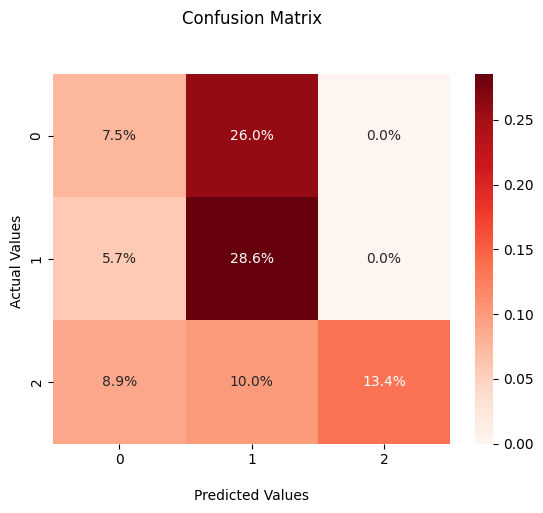

SUBJECT 10
6/6 [==============================] - 0s 6ms/step - loss: 1.0752 - accuracy: 0.4641
Score : loss of 1.0752087831497192; accuracy of 46.41460180282593%
24/24 [==============================] - 0s 2ms/step
F1 score:  0.4309540660784062
Precision:  0.4113680553655235
Recall:  0.4641460234680574


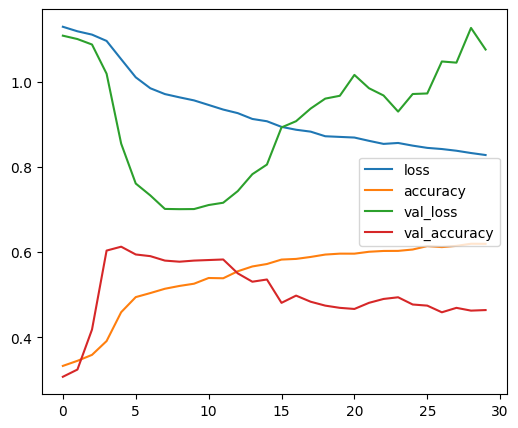

[[  1 254   0]
 [109 135  21]
 [  9  18 220]]


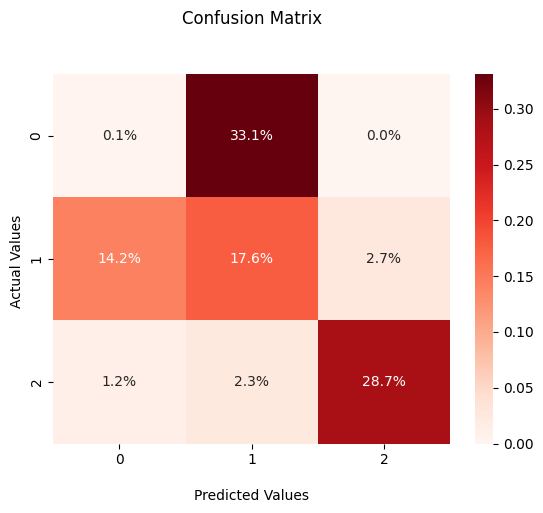

SUBJECT 11
6/6 [==============================] - 0s 8ms/step - loss: 1.4939 - accuracy: 0.3804
Score : loss of 1.4939323663711548; accuracy of 38.04347813129425%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.3788205075763205
Precision:  0.4020265785967299
Recall:  0.3804347826086957


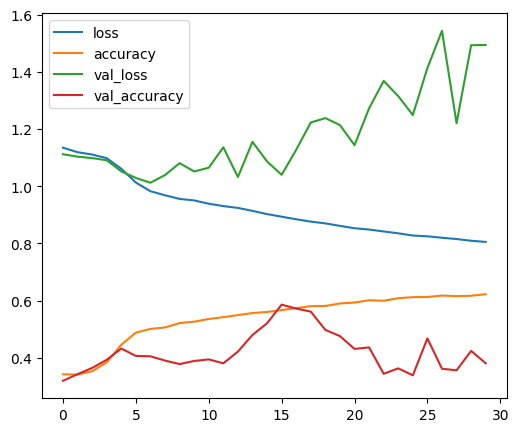

[[ 71 138  29]
 [ 55  68 132]
 [ 10  92 141]]


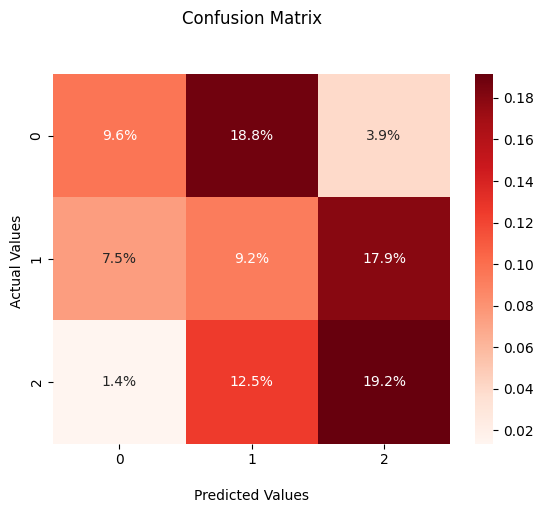

SUBJECT 12
6/6 [==============================] - 0s 6ms/step - loss: 1.0414 - accuracy: 0.5771
Score : loss of 1.0414358377456665; accuracy of 57.713496685028076%
23/23 [==============================] - 0s 2ms/step
F1 score:  0.5848296227583109
Precision:  0.6293944499725131
Recall:  0.5771349862258953


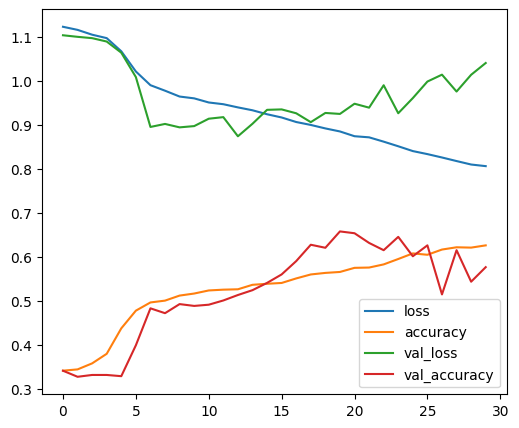

[[170  61   0]
 [143  95   7]
 [ 12  84 154]]


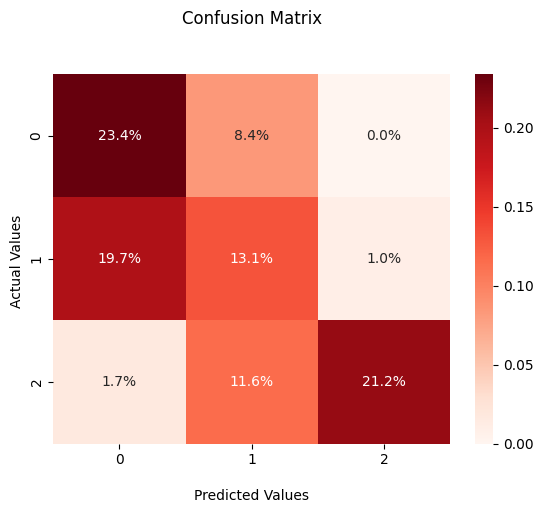

SUBJECT 13
6/6 [==============================] - 0s 8ms/step - loss: 1.0341 - accuracy: 0.4891
Score : loss of 1.0340732336044312; accuracy of 48.91008138656616%
23/23 [==============================] - 0s 2ms/step
F1 score:  0.44413173995103267
Precision:  0.4960499907202559
Recall:  0.4891008174386921


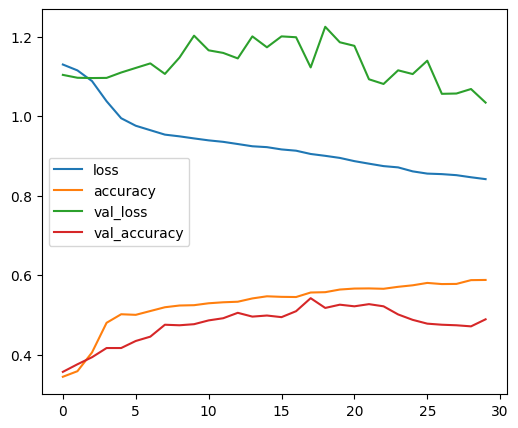

[[ 64 132  54]
 [ 16 229   0]
 [ 60 113  66]]


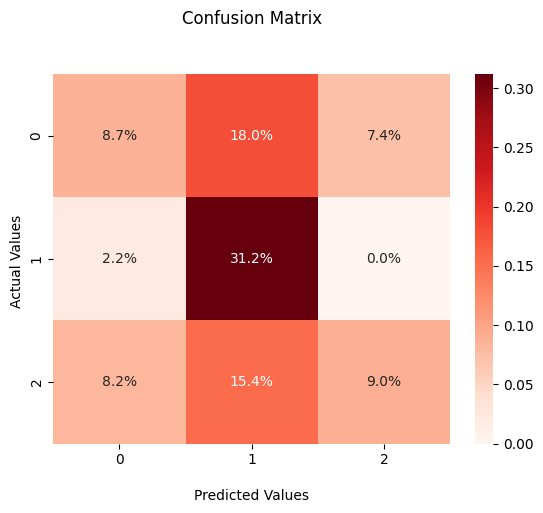

SUBJECT 14
6/6 [==============================] - 0s 7ms/step - loss: 1.1243 - accuracy: 0.4202
Score : loss of 1.1242623329162598; accuracy of 42.02127754688263%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.4335094142967497
Precision:  0.47088790446102263
Recall:  0.42021276595744683


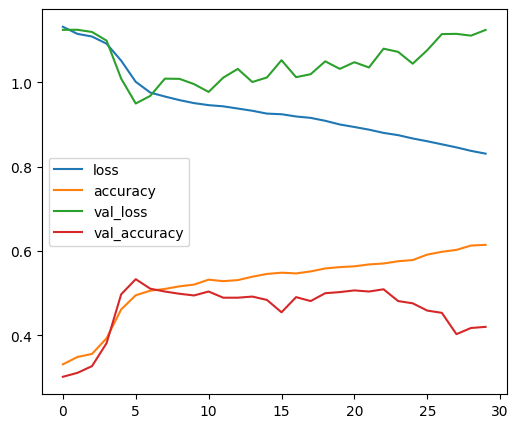

[[ 70 156  12]
 [115 115  27]
 [ 50  76 131]]


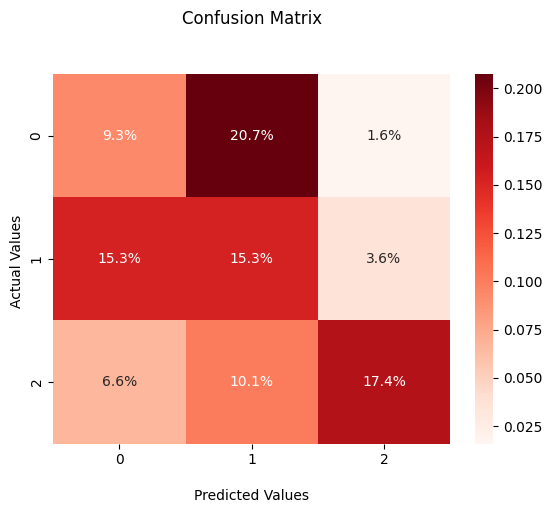

SUBJECT 15
6/6 [==============================] - 0s 7ms/step - loss: 1.2016 - accuracy: 0.3521
Score : loss of 1.2016483545303345; accuracy of 35.213205218315125%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.3404562767197258
Precision:  0.36713764432869794
Recall:  0.35213204951856947


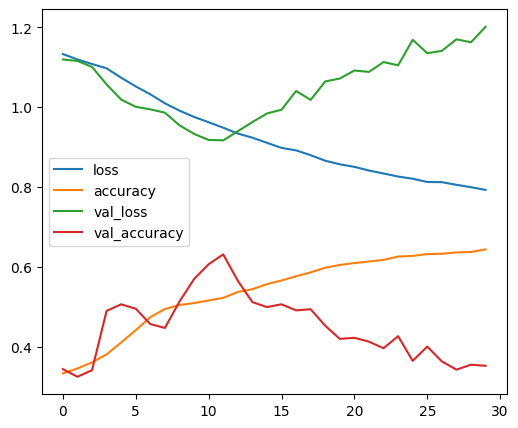

[[ 82 103  65]
 [116 126   0]
 [ 41 146  48]]


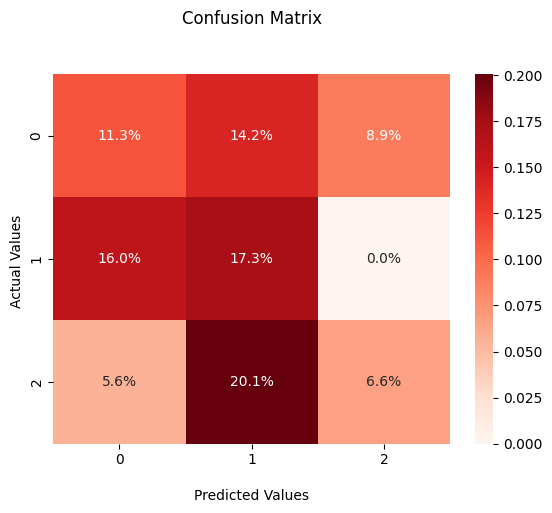

SUBJECT 16
6/6 [==============================] - 0s 7ms/step - loss: 0.9999 - accuracy: 0.4933
Score : loss of 0.9999486804008484; accuracy of 49.3261456489563%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.4539426945087322
Precision:  0.43816480529056745
Recall:  0.49326145552560646


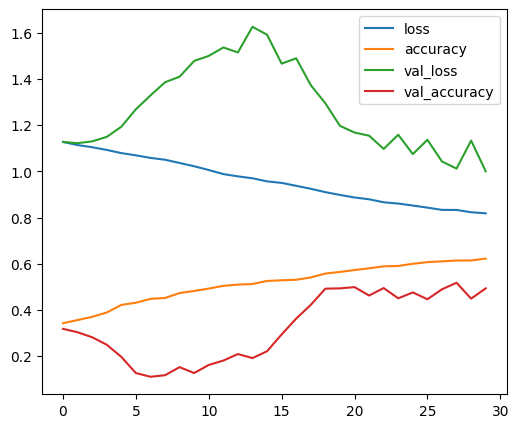

[[  0 252   0]
 [ 90 149   6]
 [  8  20 217]]


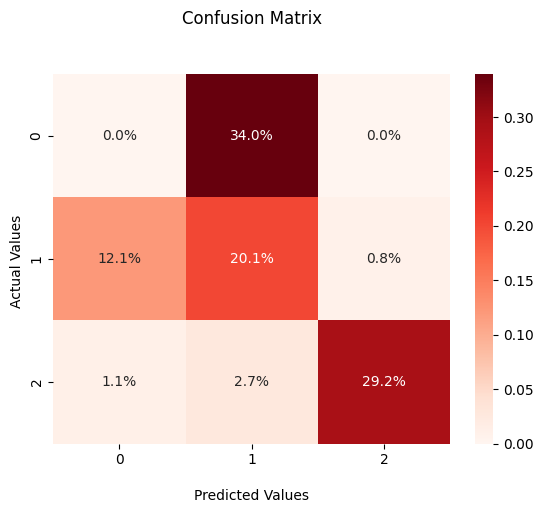

SUBJECT 17
6/6 [==============================] - 0s 6ms/step - loss: 1.4064 - accuracy: 0.3930
Score : loss of 1.4064275026321411; accuracy of 39.304813742637634%
24/24 [==============================] - 0s 2ms/step
F1 score:  0.34142527642150966
Precision:  0.30202961962626235
Recall:  0.393048128342246


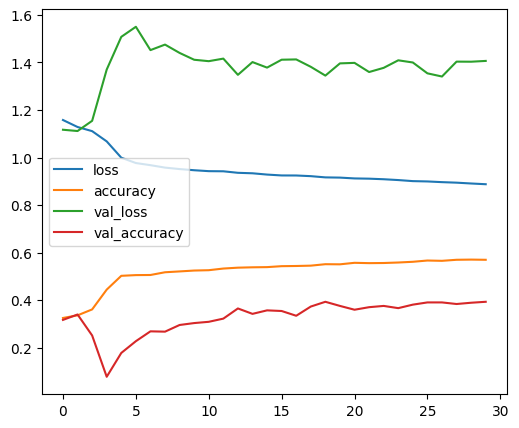

[[177  83   0]
 [ 53 117  79]
 [ 97 142   0]]


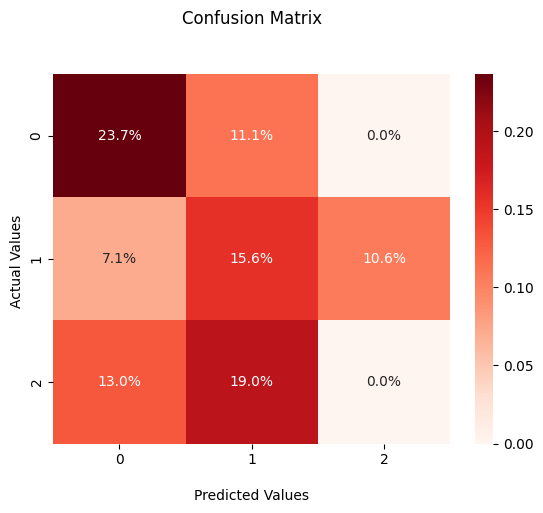

SUBJECT 18
6/6 [==============================] - 0s 6ms/step - loss: 0.8428 - accuracy: 0.5466
Score : loss of 0.8428068161010742; accuracy of 54.6558678150177%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.4747040416916096
Precision:  0.4486741583703787
Recall:  0.5465587044534413


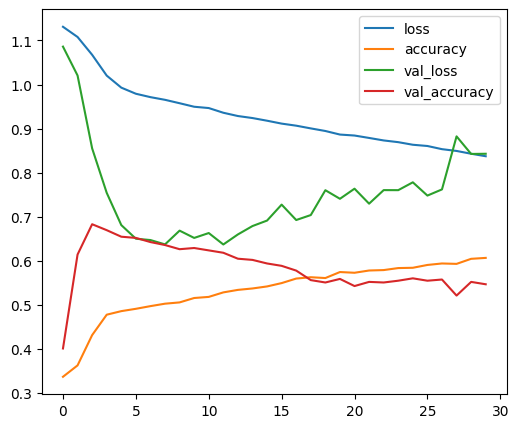

[[  3 248   0]
 [ 33 182  30]
 [  8  17 220]]


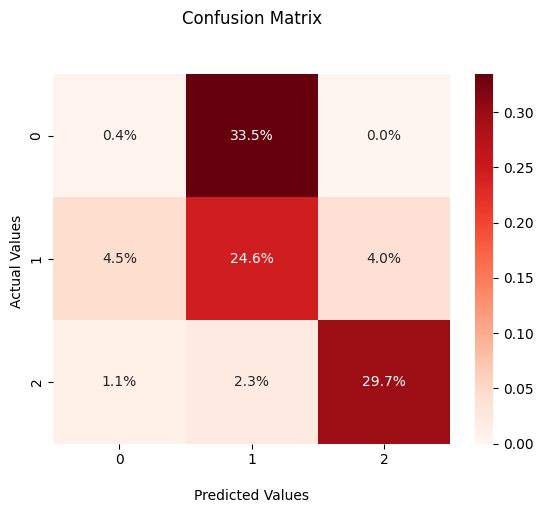

SUBJECT 19
6/6 [==============================] - 0s 6ms/step - loss: 0.6371 - accuracy: 0.6791
Score : loss of 0.6371433734893799; accuracy of 67.9114818572998%
23/23 [==============================] - 0s 2ms/step
F1 score:  0.6163580801770501
Precision:  0.6772662480110345
Recall:  0.6791147994467497


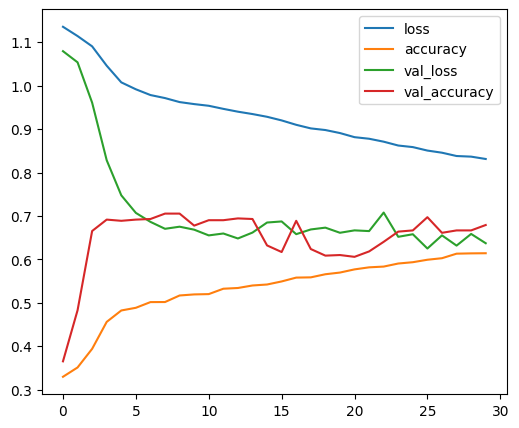

[[ 42  66 136]
 [ 18 223   0]
 [  4   8 226]]


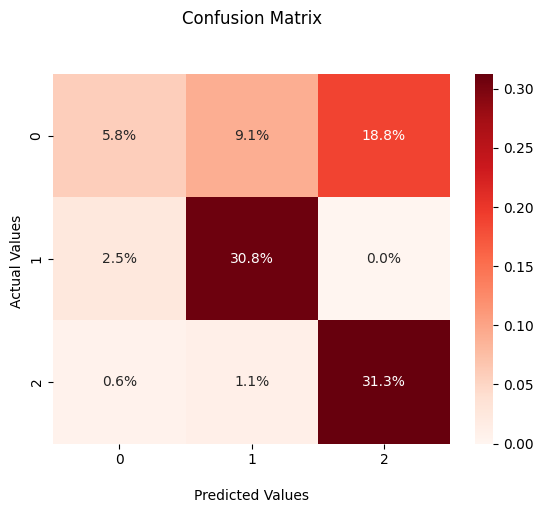

SUBJECT 20
6/6 [==============================] - 0s 7ms/step - loss: 1.0732 - accuracy: 0.3189
Score : loss of 1.0731834173202515; accuracy of 31.88602328300476%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.2801552385221311
Precision:  0.3540017975644853
Recall:  0.31886024423337855


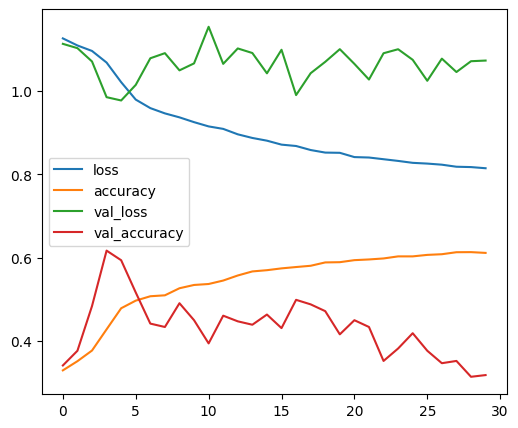

[[143  76  21]
 [150  78  11]
 [240   4  14]]


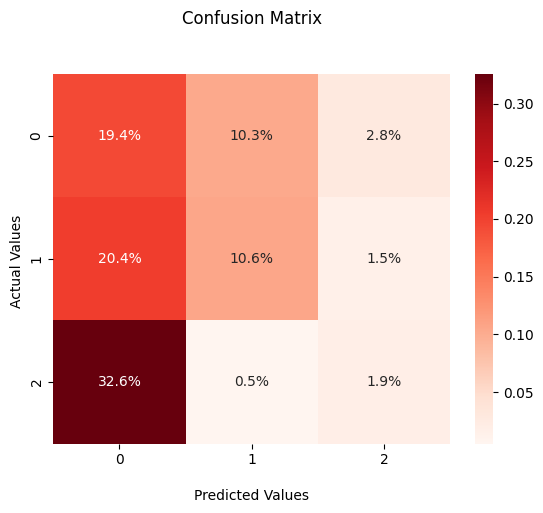

SUBJECT 21
6/6 [==============================] - 0s 7ms/step - loss: 1.5233 - accuracy: 0.3876
Score : loss of 1.523334264755249; accuracy of 38.758620619773865%
23/23 [==============================] - 0s 2ms/step
F1 score:  0.31860651280885766
Precision:  0.3207662544757366
Recall:  0.3875862068965517


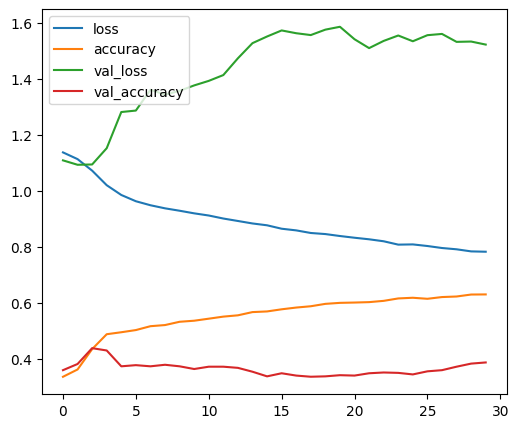

[[ 17 122  97]
 [ 15 212  16]
 [ 55 139  52]]


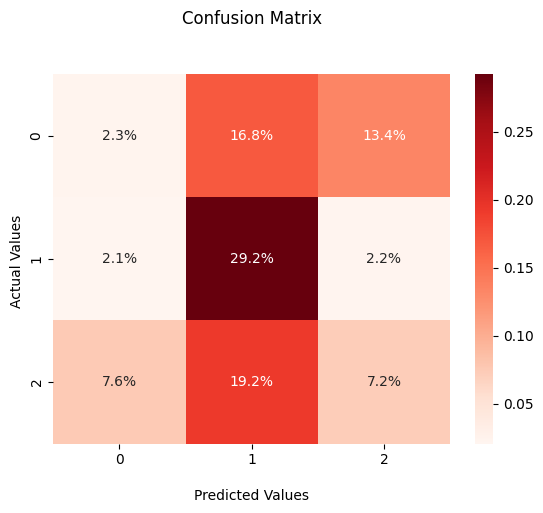

In [ ]:
from sklearn.model_selection import train_test_split

for sub in range(len(all_data)):

    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(test_data_all['data'], test_data_all['label'],
                                                                                 test_size=0.2, random_state=3456789)

    train_data, train_data_all = {}, {}
    test_data = {}
    
    train_data_all["data"] = np.concatenate([all_data[i]["data"] for i in range(len(all_data)) if i != sub])    
    train_data['data'] = np.concatenate((train_data_all['data'], X_test_split), axis=0)
    
    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split), axis=0)
    
    test_data['data'] = X_train_split
    test_data['label'] = y_train_split

    cm_w_ft_20, acc_w_ft_20, loss_w_ft_20, f1_w_ft_20, prec_w_ft_20, rec_w_ft_20 = transformers(train_data, test_data)

**Average accuracy and F1 score (20% ft)**

In [12]:
print(acc_w_ft_20)

[51.0869562625885, 22.043010592460632, 53.51351499557495, 50.67750811576843, 18.44262331724167, 21.448087692260742, 42.99191236495972, 71.0597813129425, 43.65411400794983, 49.453550577163696, 46.41460180282593, 38.04347813129425, 57.713496685028076, 48.91008138656616, 42.02127754688263, 35.213205218315125, 49.3261456489563, 39.304813742637634, 54.6558678150177, 67.9114818572998, 31.88602328300476, 38.758620619773865]


In [13]:
print(np.mean(acc_w_ft_20))
print(np.mean(f1_w_ft_20))

44.29682513529604
0.40871154421994704


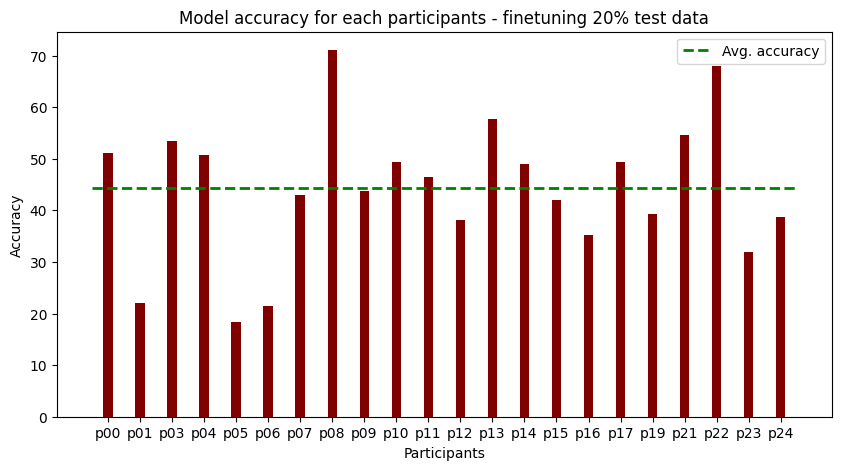

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_20, color ='maroon',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 20% test data")

plt.hlines(y=(np.mean(acc_w_ft_20)), xmin=-0.5, xmax=(len(f1_w_ft_20)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

# **Transformers accuracy on LOSO with and without finetuning**

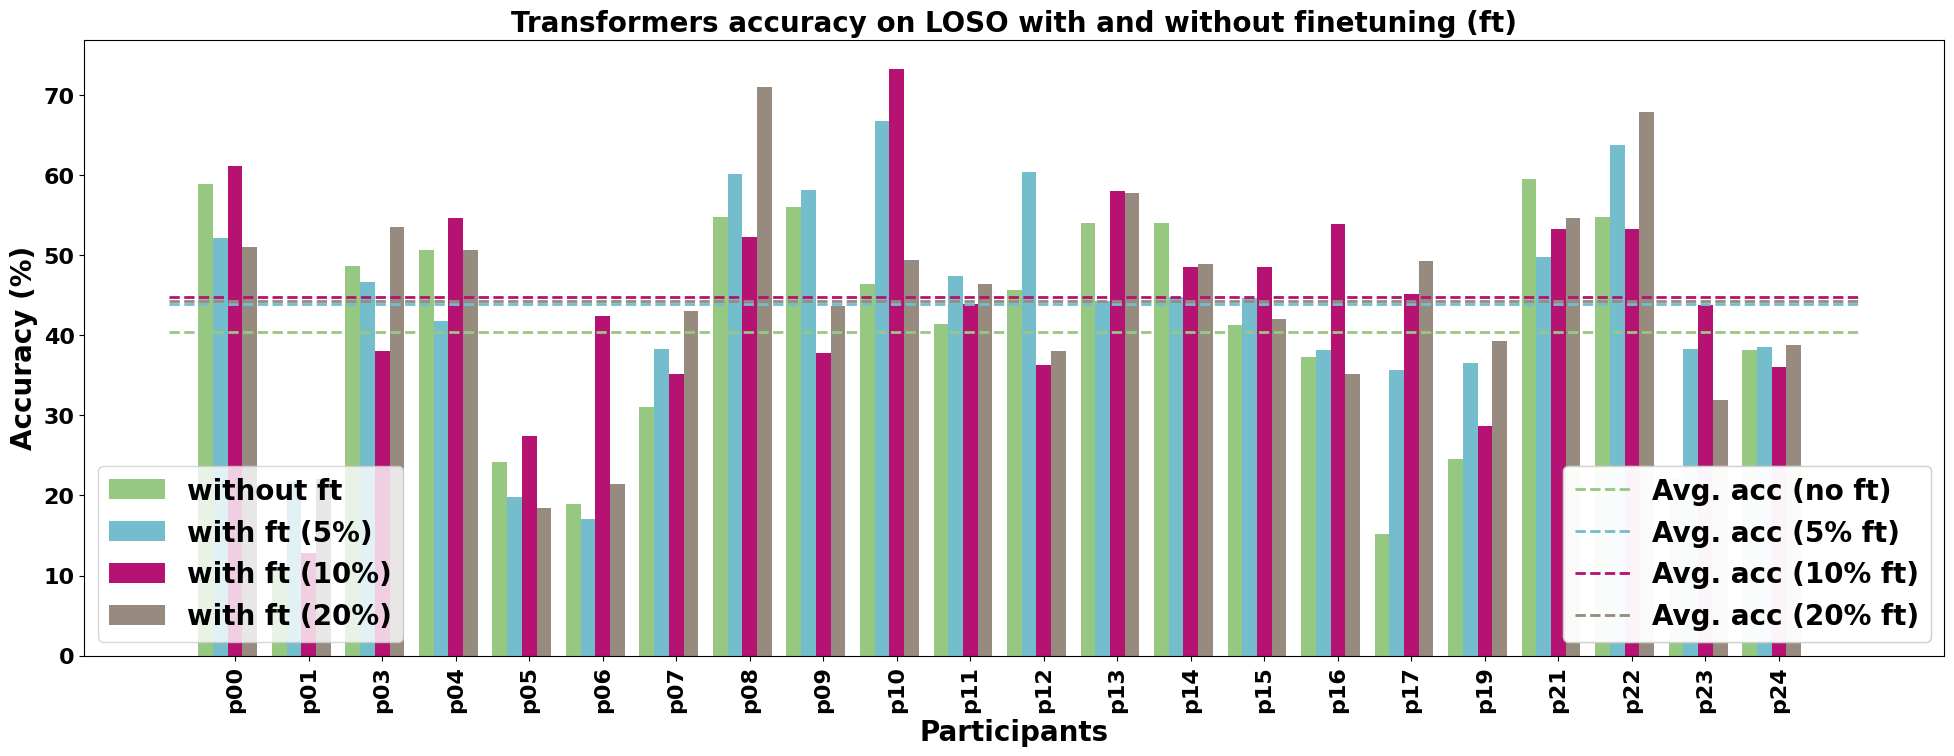

In [16]:
import matplotlib.font_manager as font_manager

N = 22
ind = np.arange(N) 
width = 0.2

plt.rcParams['figure.figsize'] = [24, 8]
wo_ft = acc_w_o_ft
bar1 = plt.bar(ind, wo_ft, width, color = '#97c881')

w_ft_5 = acc_w_ft_5
bar2 = plt.bar(ind+width, w_ft_5, width, color = '#74bdcd')
  
w_ft_10 = acc_w_ft_10
bar3 = plt.bar(ind+width*2, w_ft_10, width, color='#b51272')
  
w_ft_20 = acc_w_ft_20
bar4 = plt.bar(ind+width*3, w_ft_20, width, color = '#978b7f')

font = font_manager.FontProperties(weight='bold', style='normal', size=20)
  
plt.xlabel("Participants",fontsize=20, fontweight='bold')
plt.ylabel('Accuracy (%)',fontsize=20, fontweight='bold')
plt.title("Transformers accuracy on LOSO with and without finetuning (ft)",fontsize=20, fontweight='bold')
  
plt.xticks(ind+width*2,participants)
plt.xticks(fontsize=16, rotation=90, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

legend1 = plt.legend( (bar1, bar2, bar3, bar4), ('without ft', 'with ft (5%)', 'with ft (10%)', 'with ft (20%)'), loc = 3, prop=font )
plt.hlines(y=(np.mean(wo_ft)), xmin=-0.5, xmax=(len(wo_ft)+0.5), colors='#97c881', lw=2, label='Avg. acc (no ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_5)), xmin=-0.5, xmax=(len(w_ft_5)+0.5), colors='#74bdcd', lw=2, label='Avg. acc (5% ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_10)), xmin=-0.5, xmax=(len(w_ft_10)+0.5), colors='#b51272', lw=2, label='Avg. acc (10% ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_20)), xmin=-0.5, xmax=(len(w_ft_20)+0.5), colors='#978b7f', lw=2, label='Avg. acc (20% ft)', linestyles='--')
legend2 = plt.legend(loc = 4, prop=font)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
#plt.savefig('transf_LOSO_4.pdf') 
plt.show()